In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from config import attr_interval_dict, all_metrics, all_brain_regions, all_event_types
from analysis.timepoint_analysis import sample_low_and_high_signals
from plotting.main_plotting import plot_signals, plot_signals_p_values
import matplotlib.pyplot as plt


sessions = load_and_prepare_sessions("../../../Baseline", load_from_pickle=True, remove_bad_signal_sessions=True)
mouse_analyser = MiceAnalysis(sessions)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


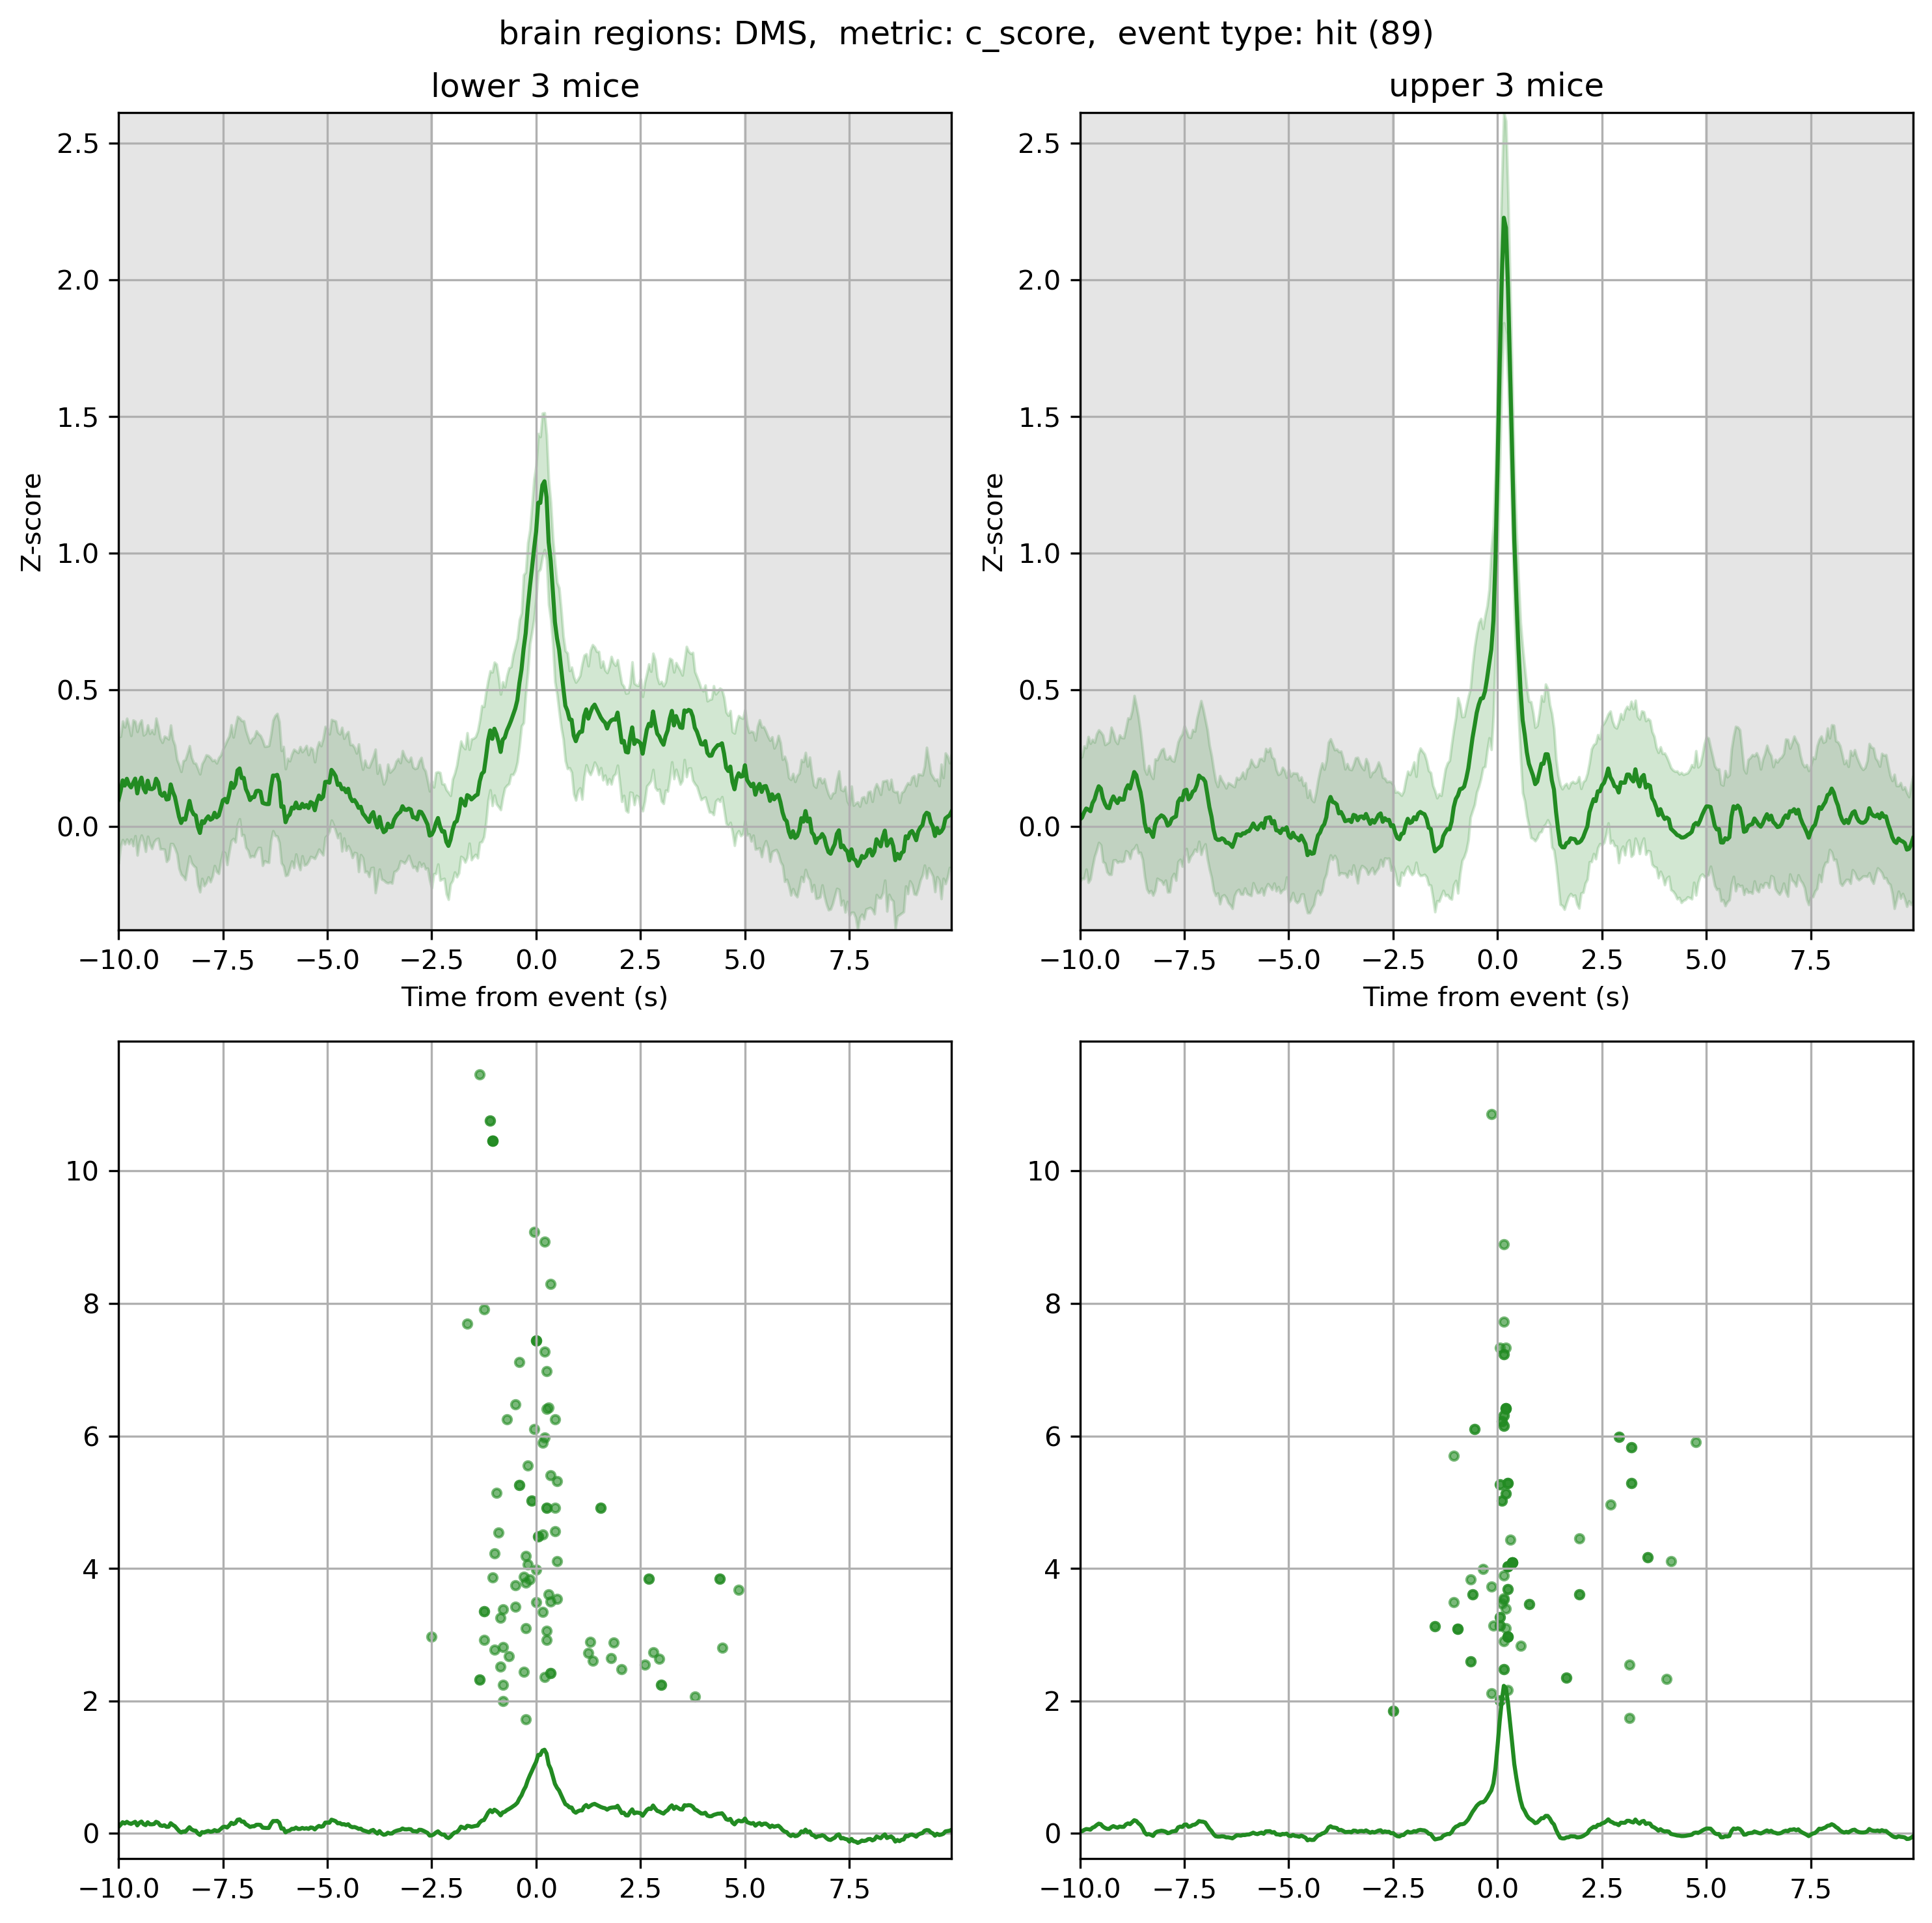

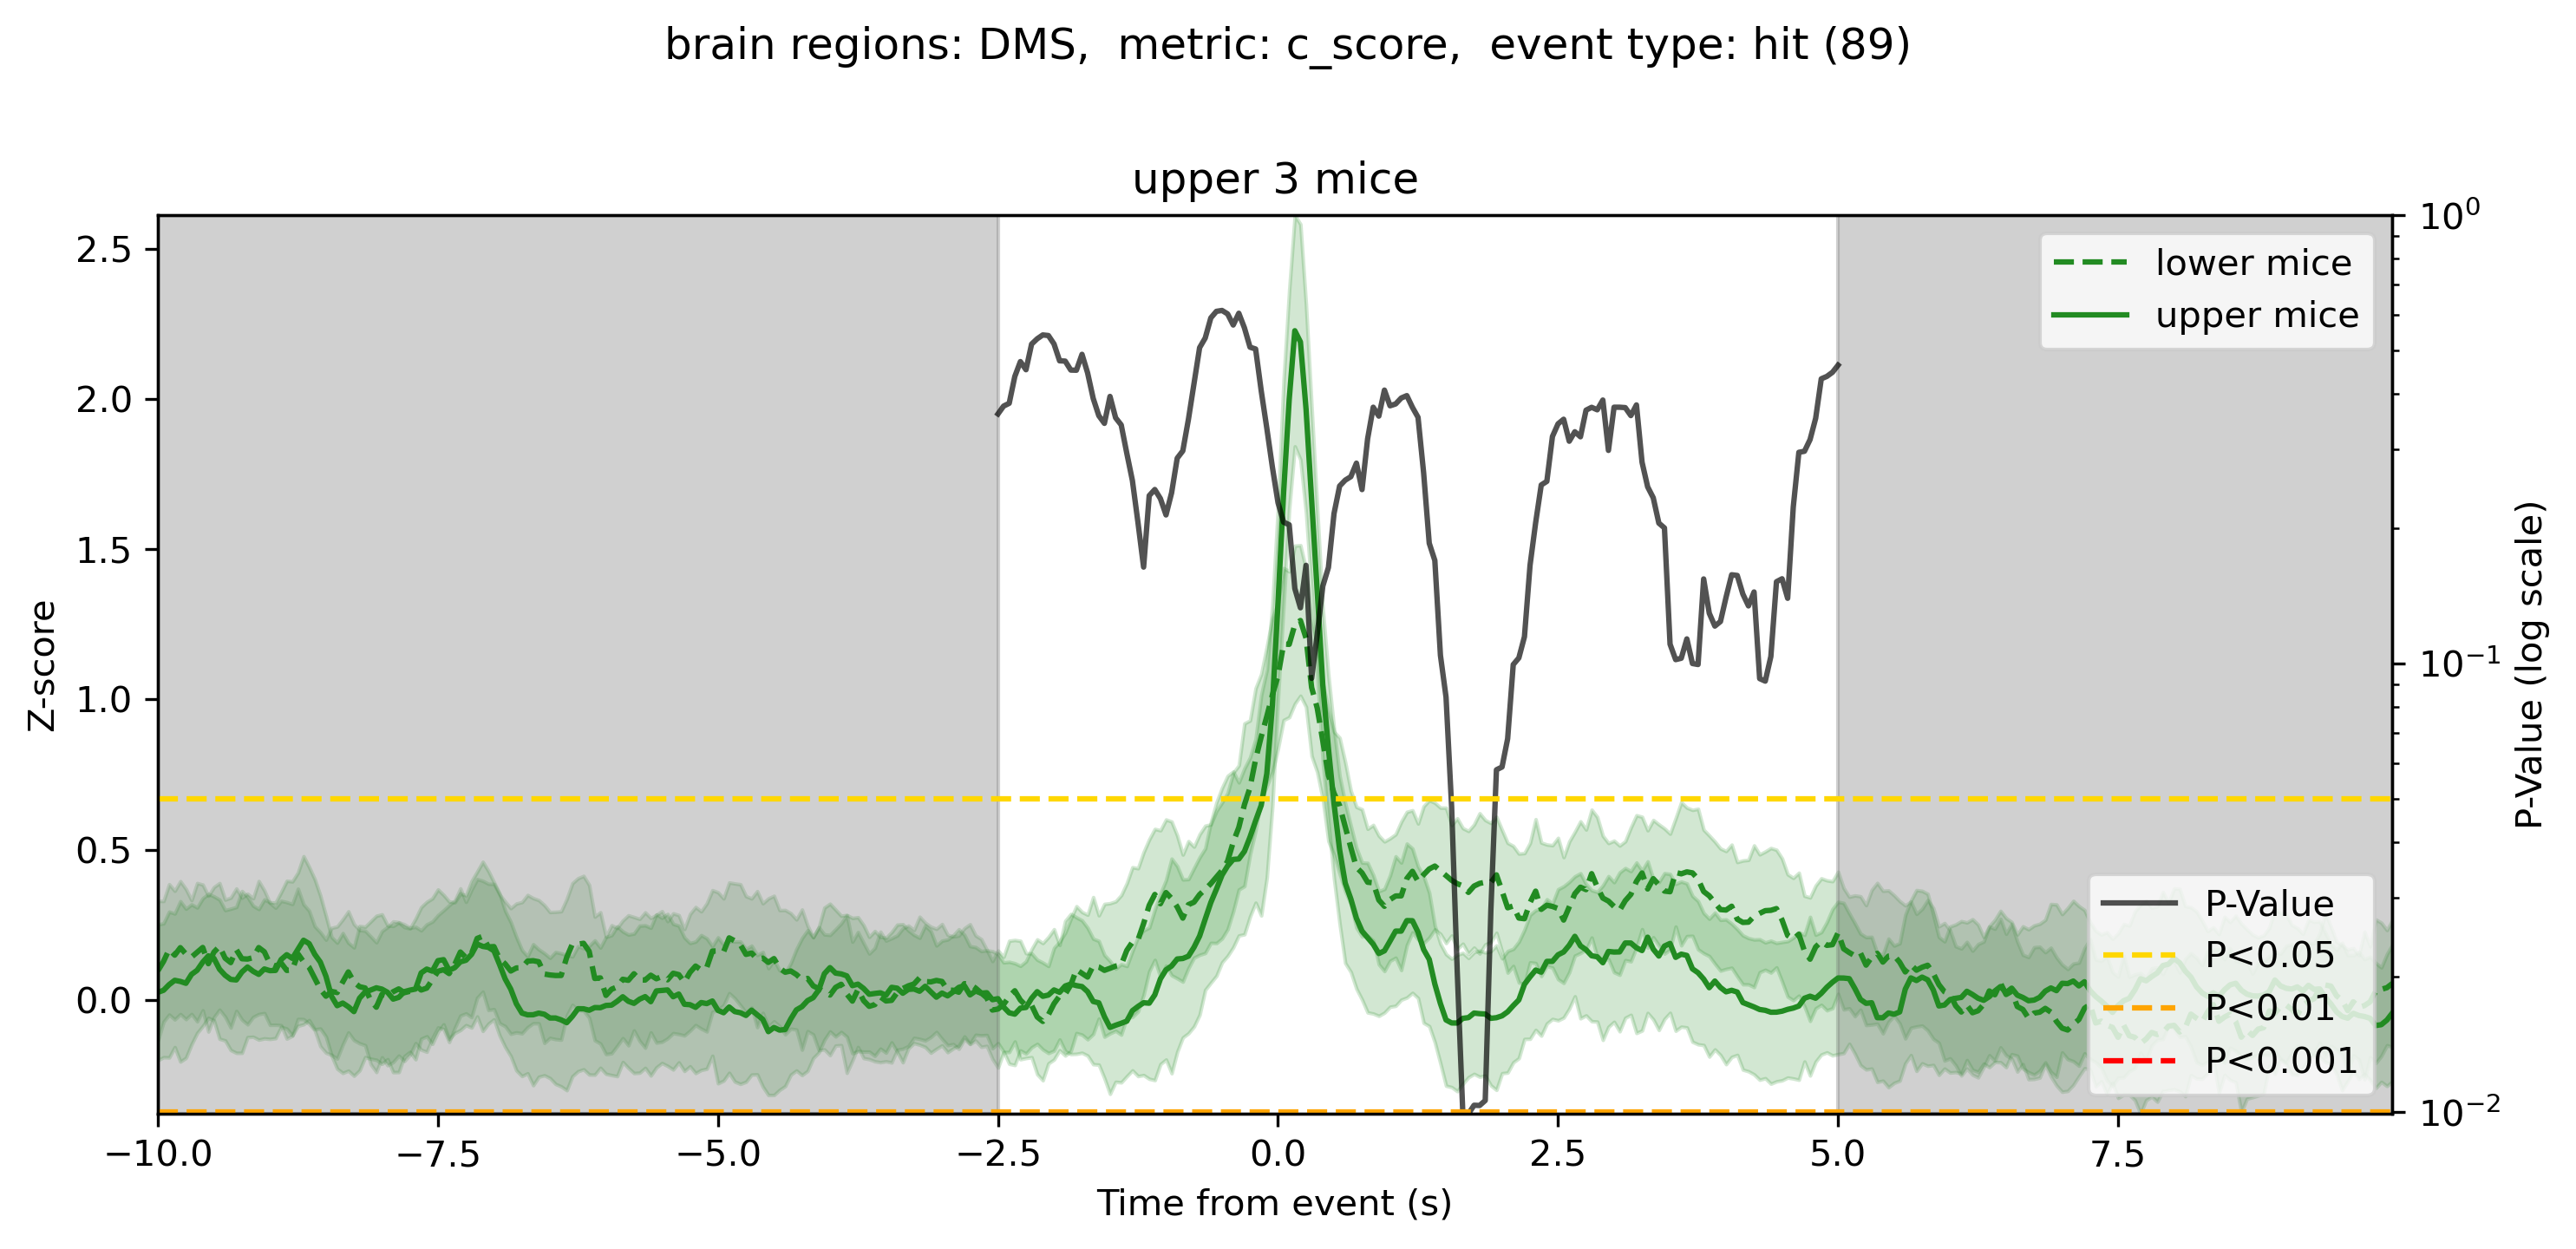

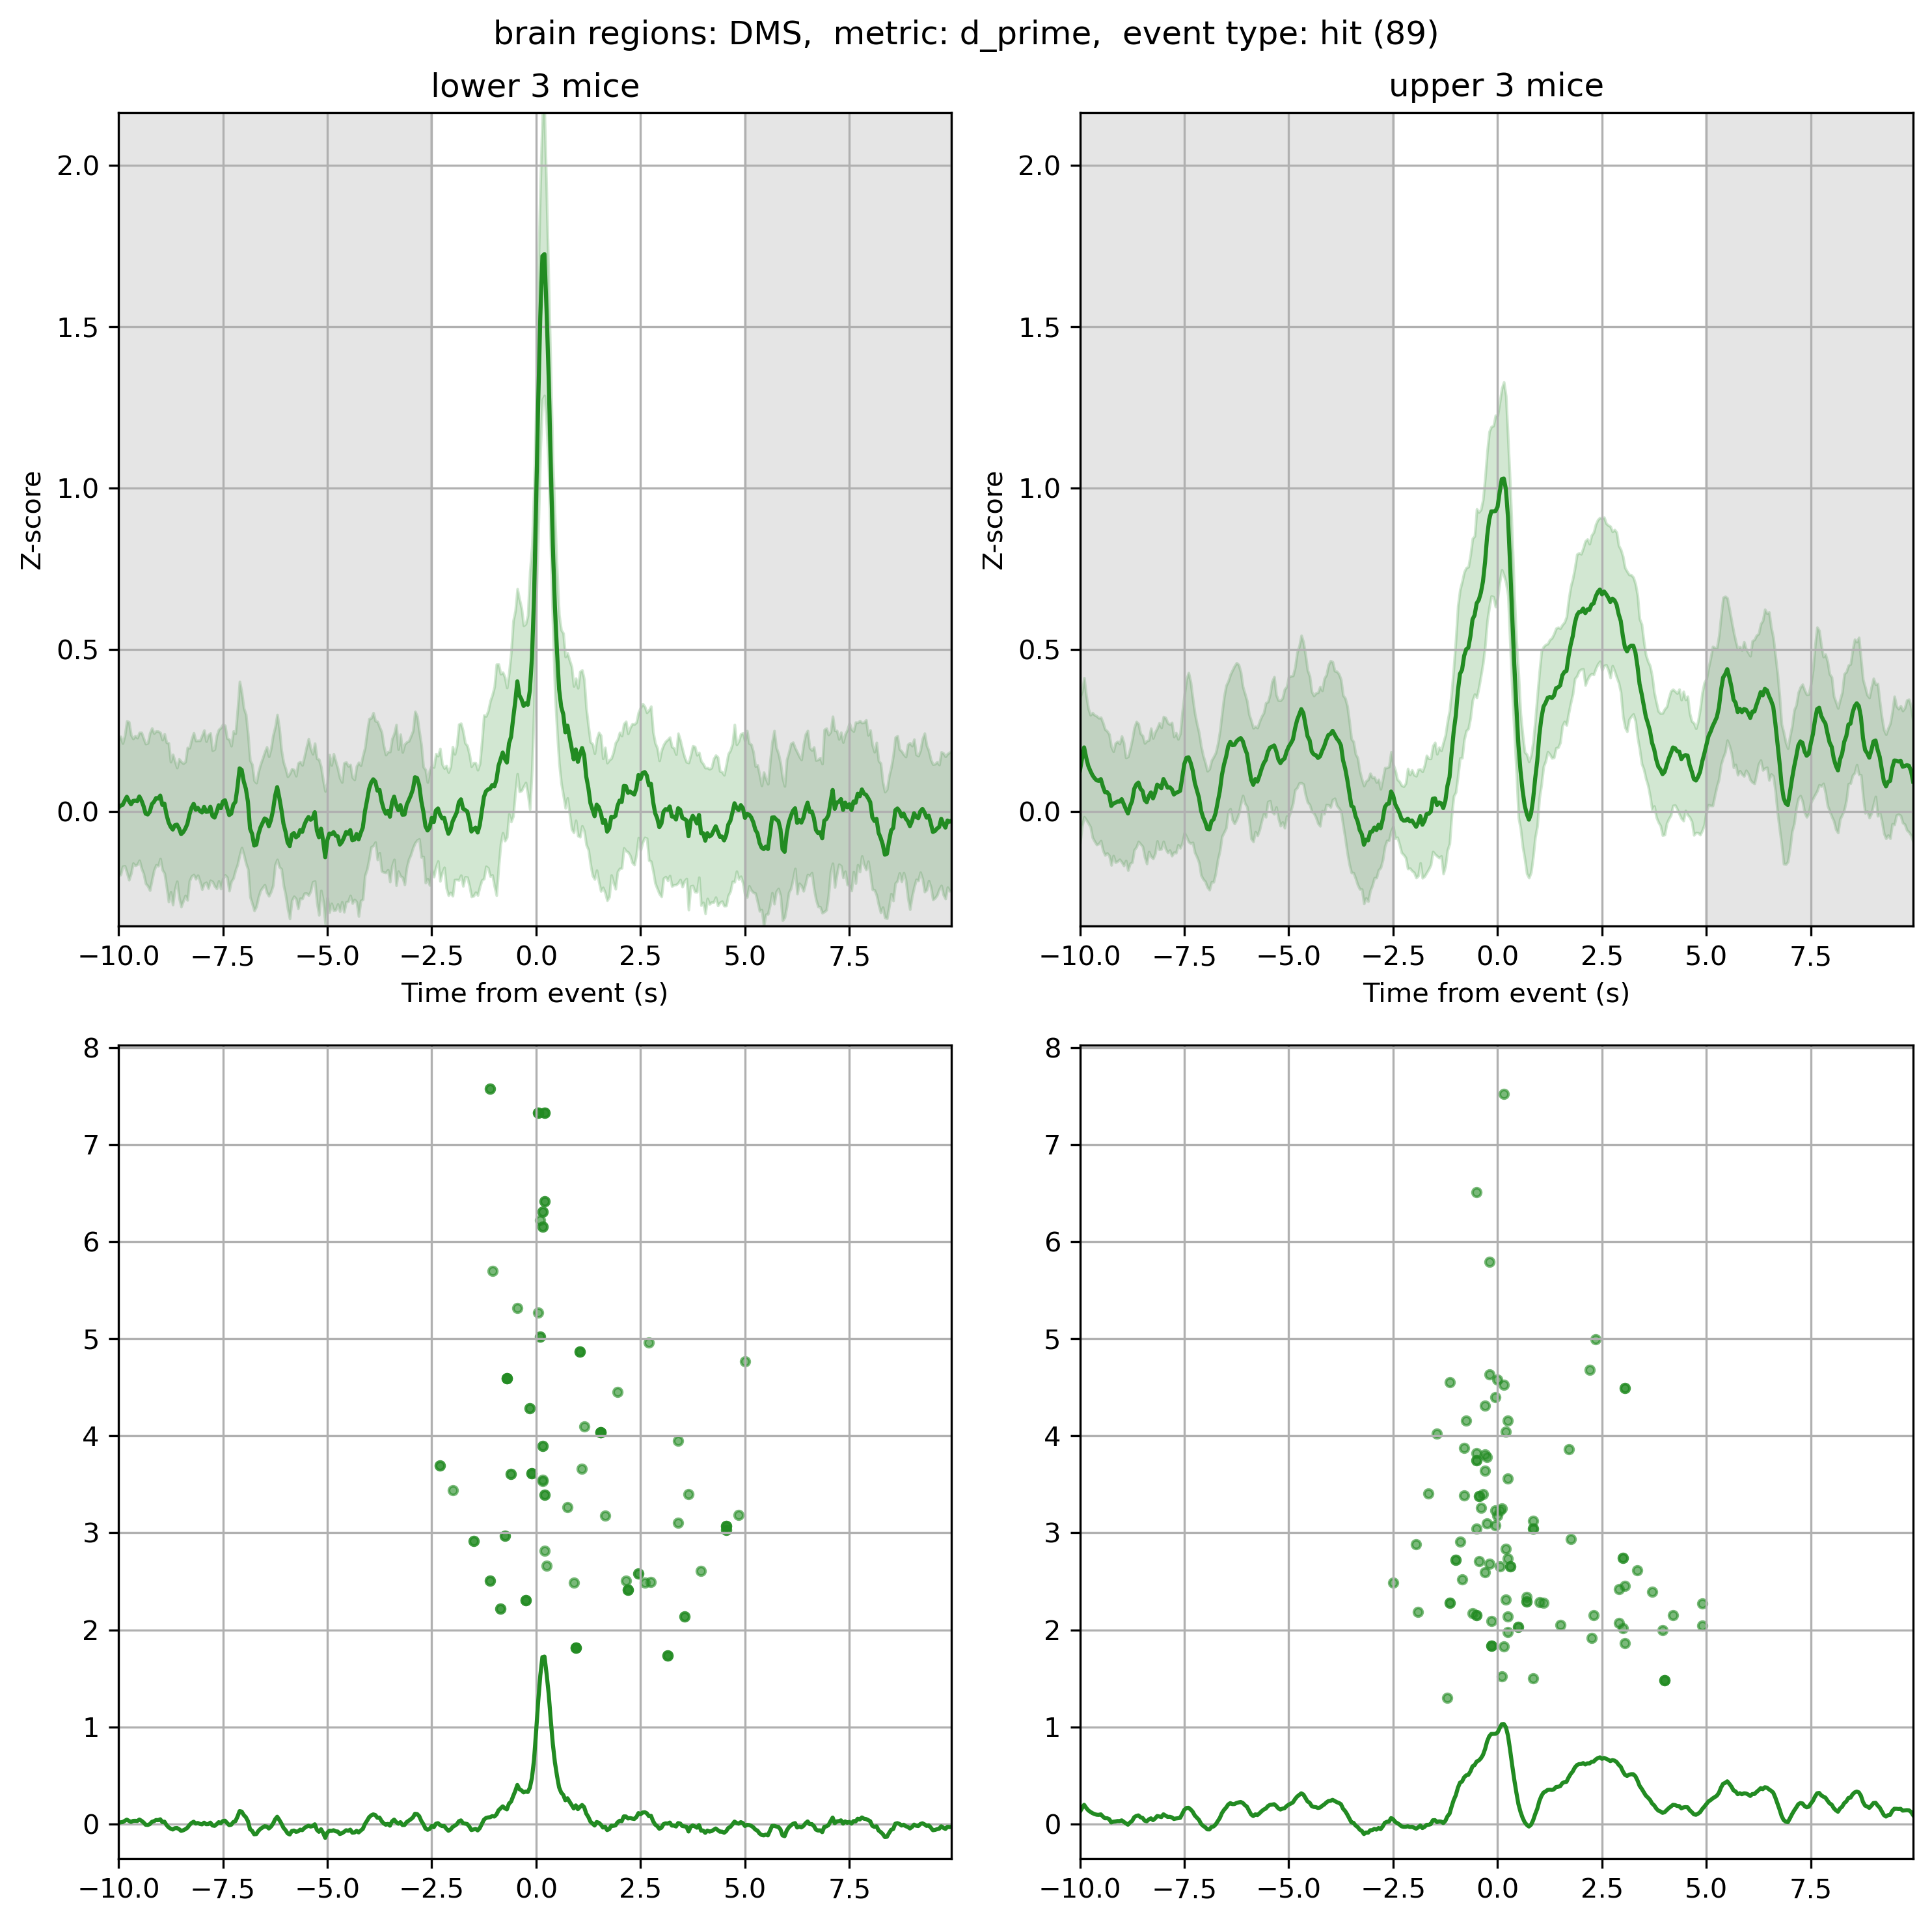

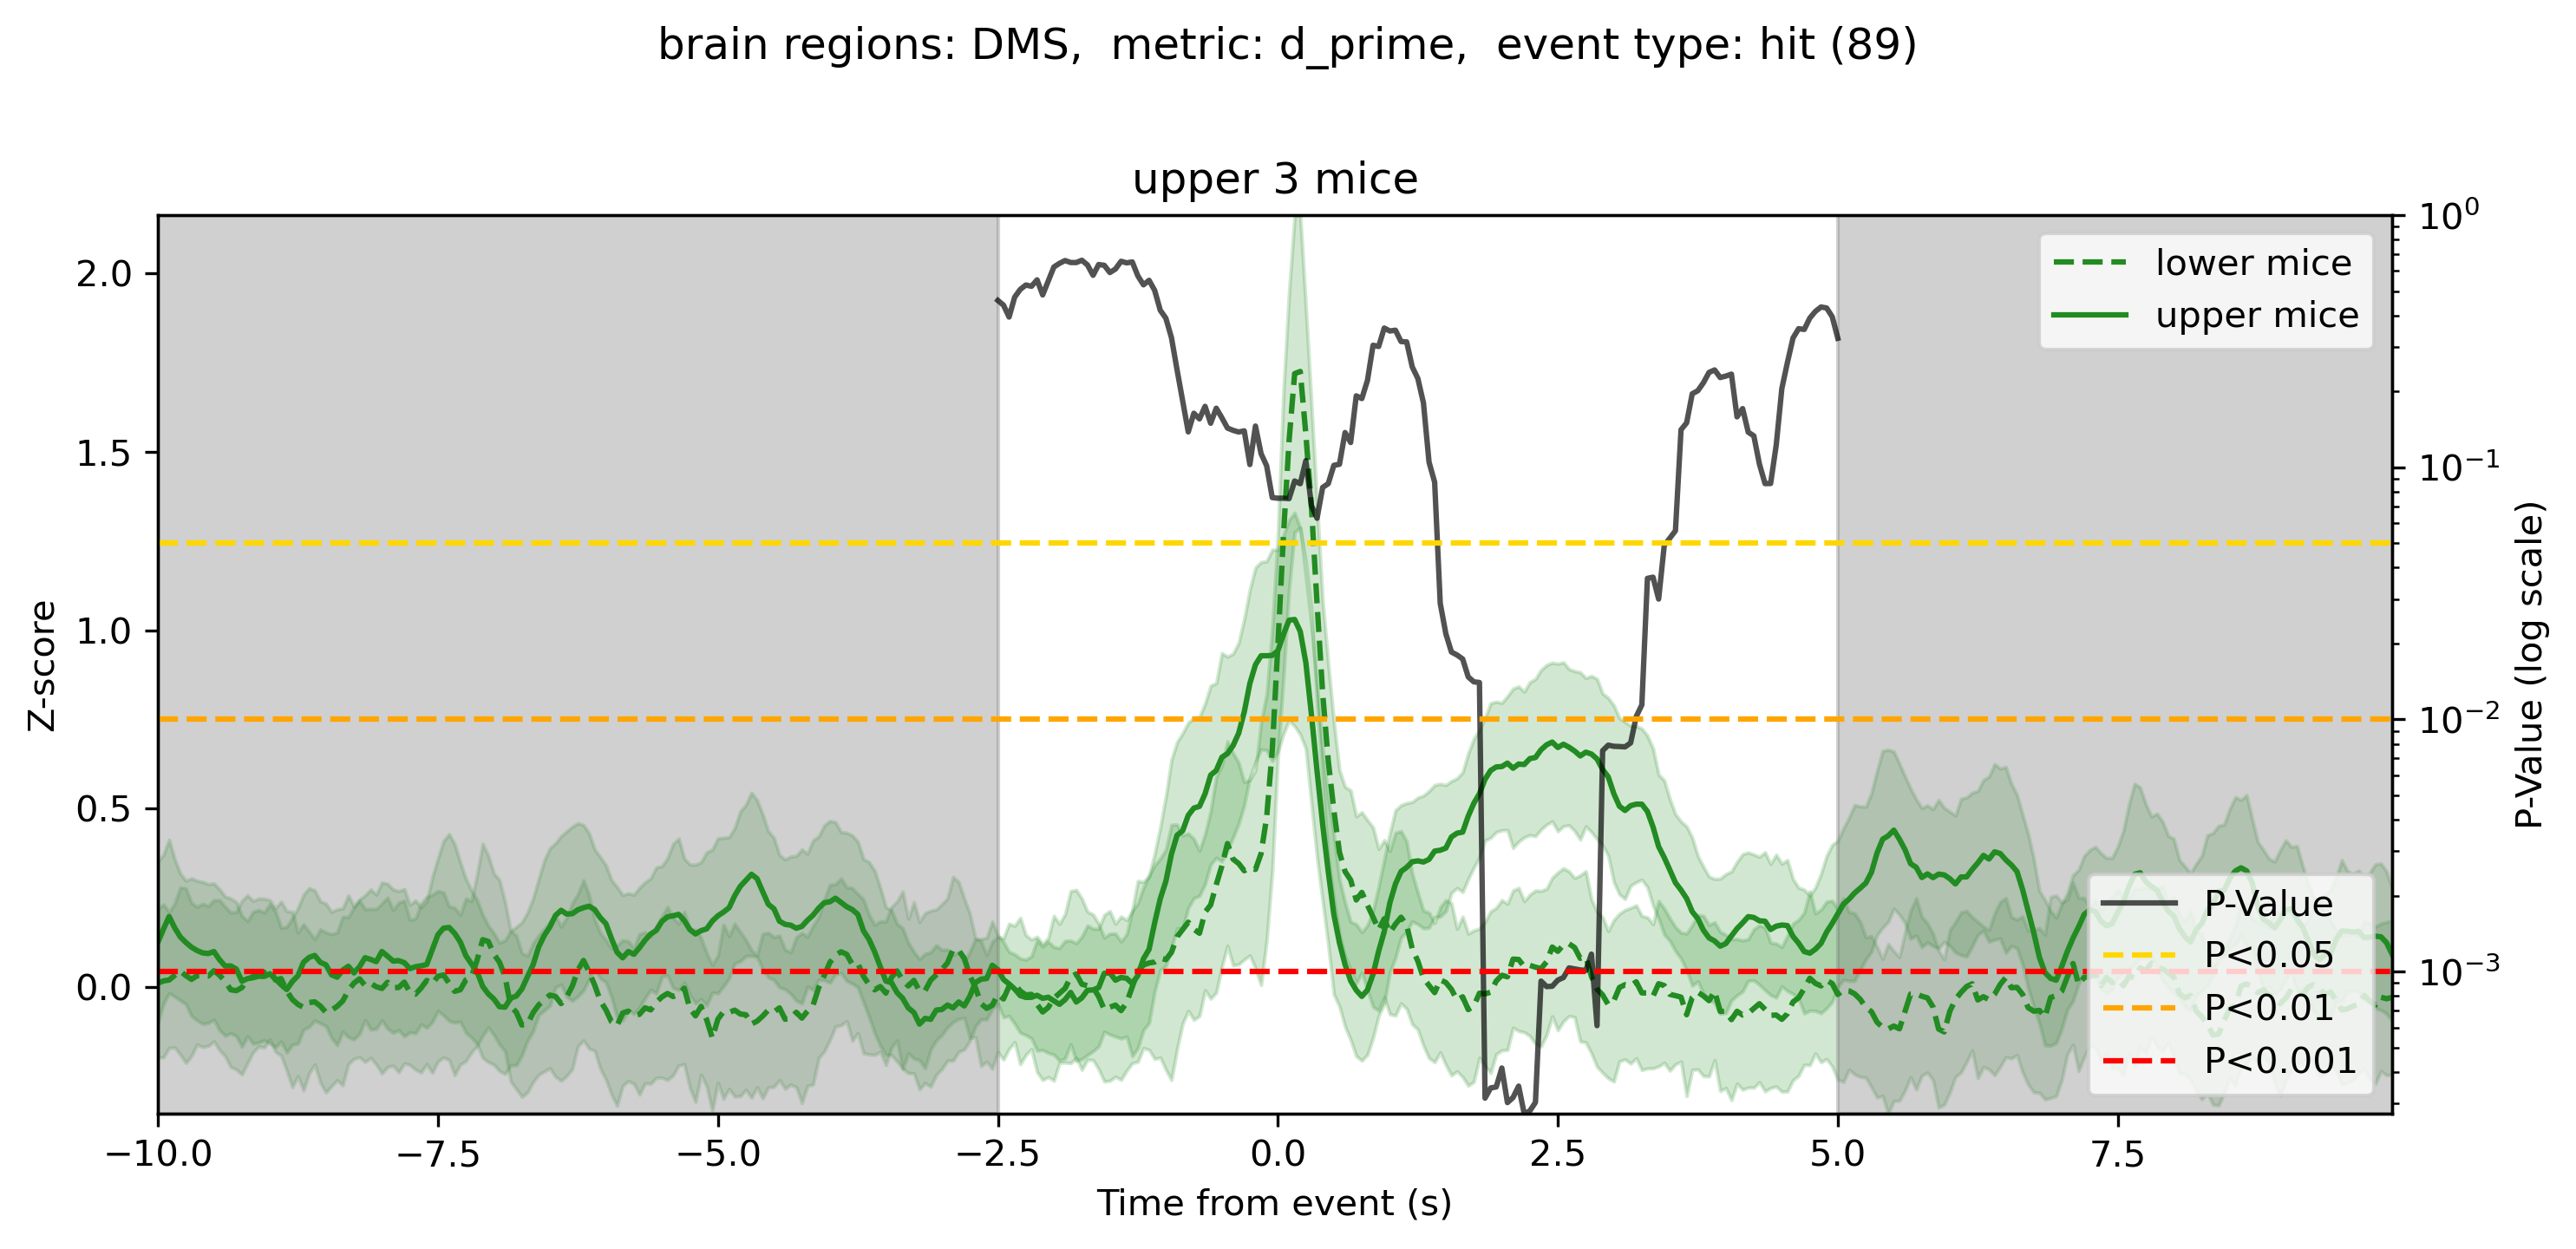

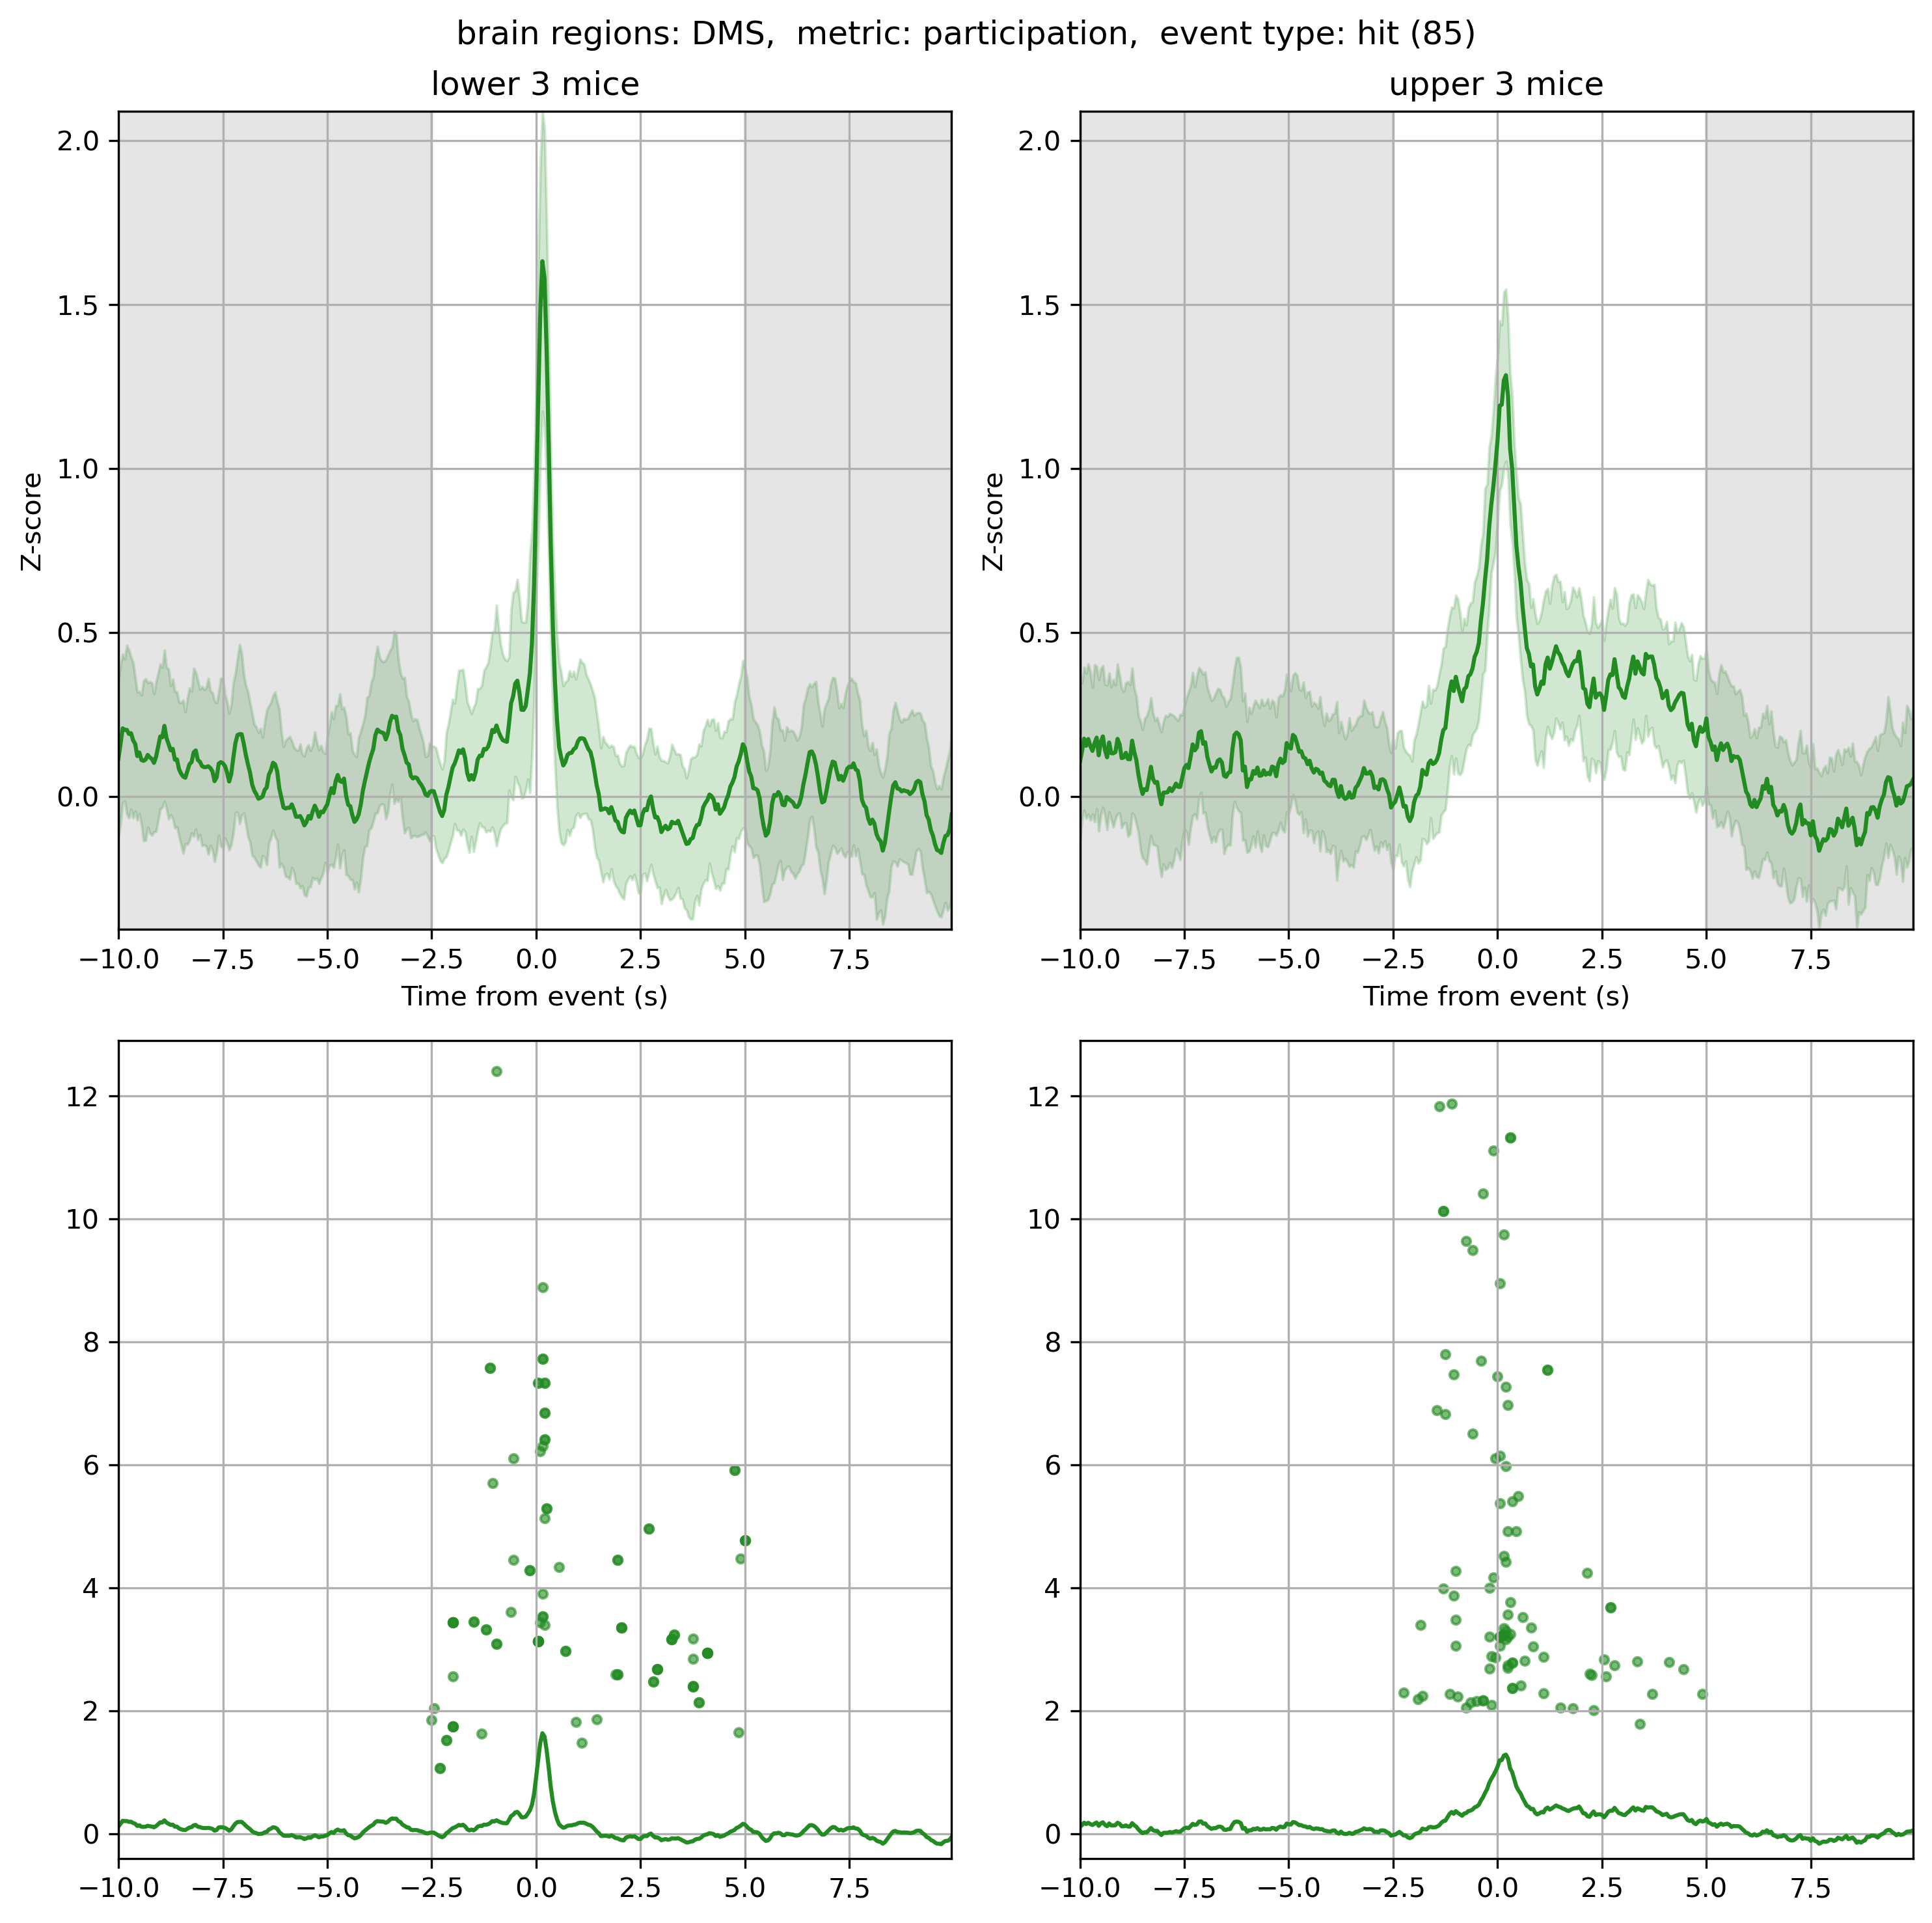

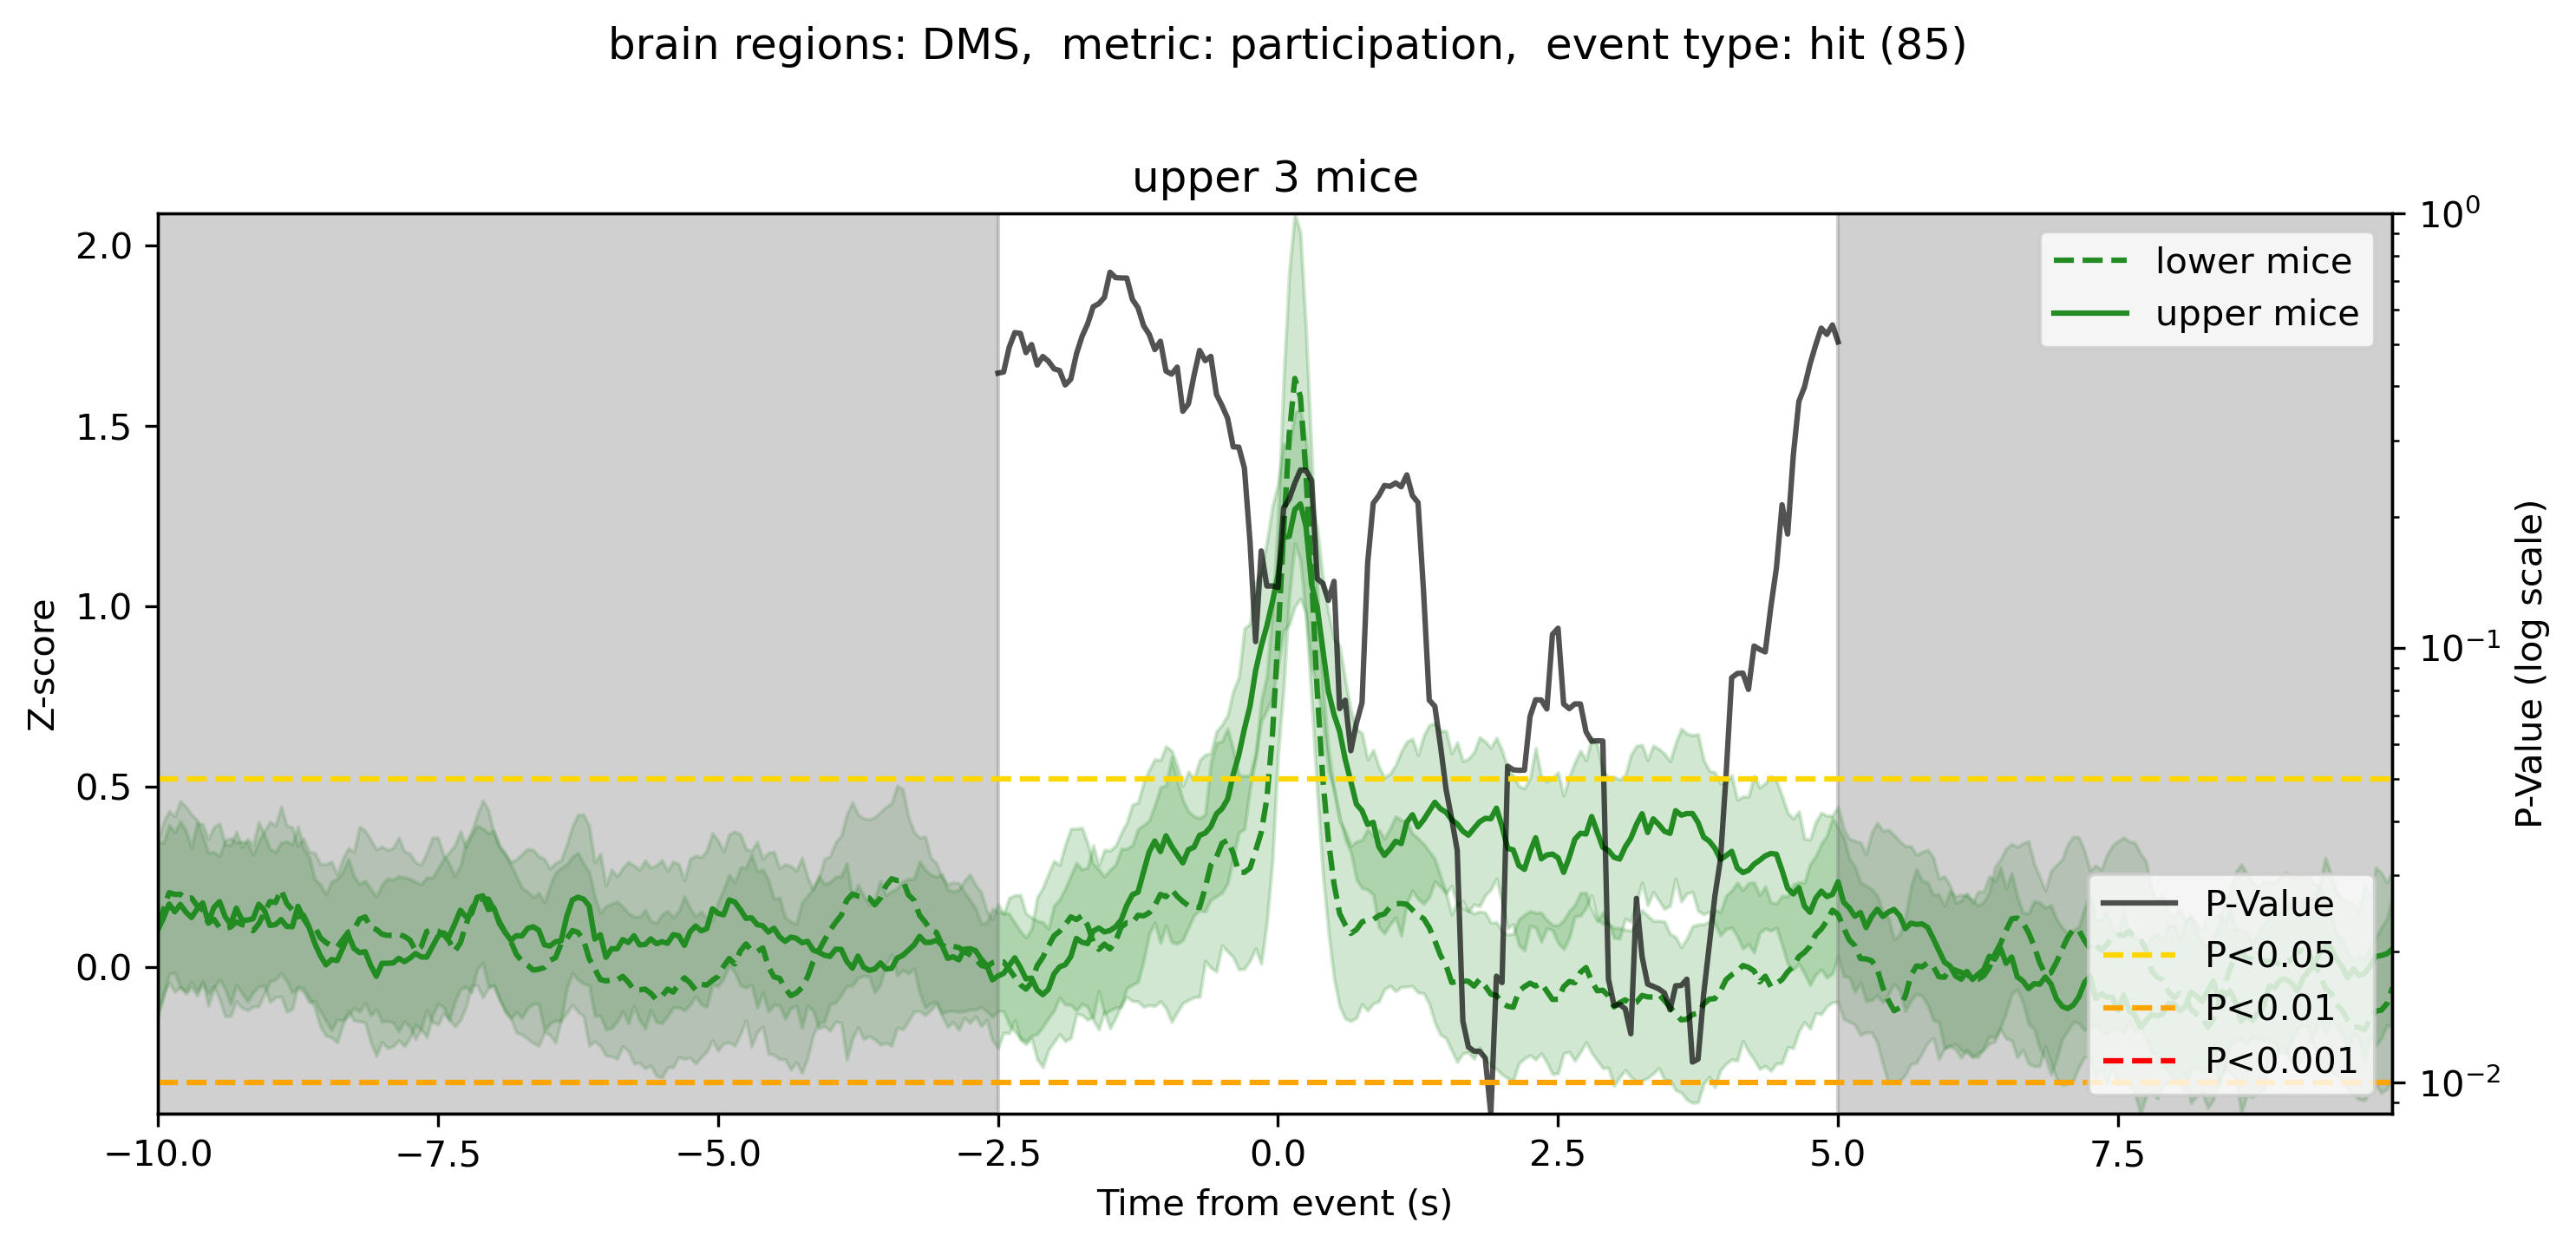

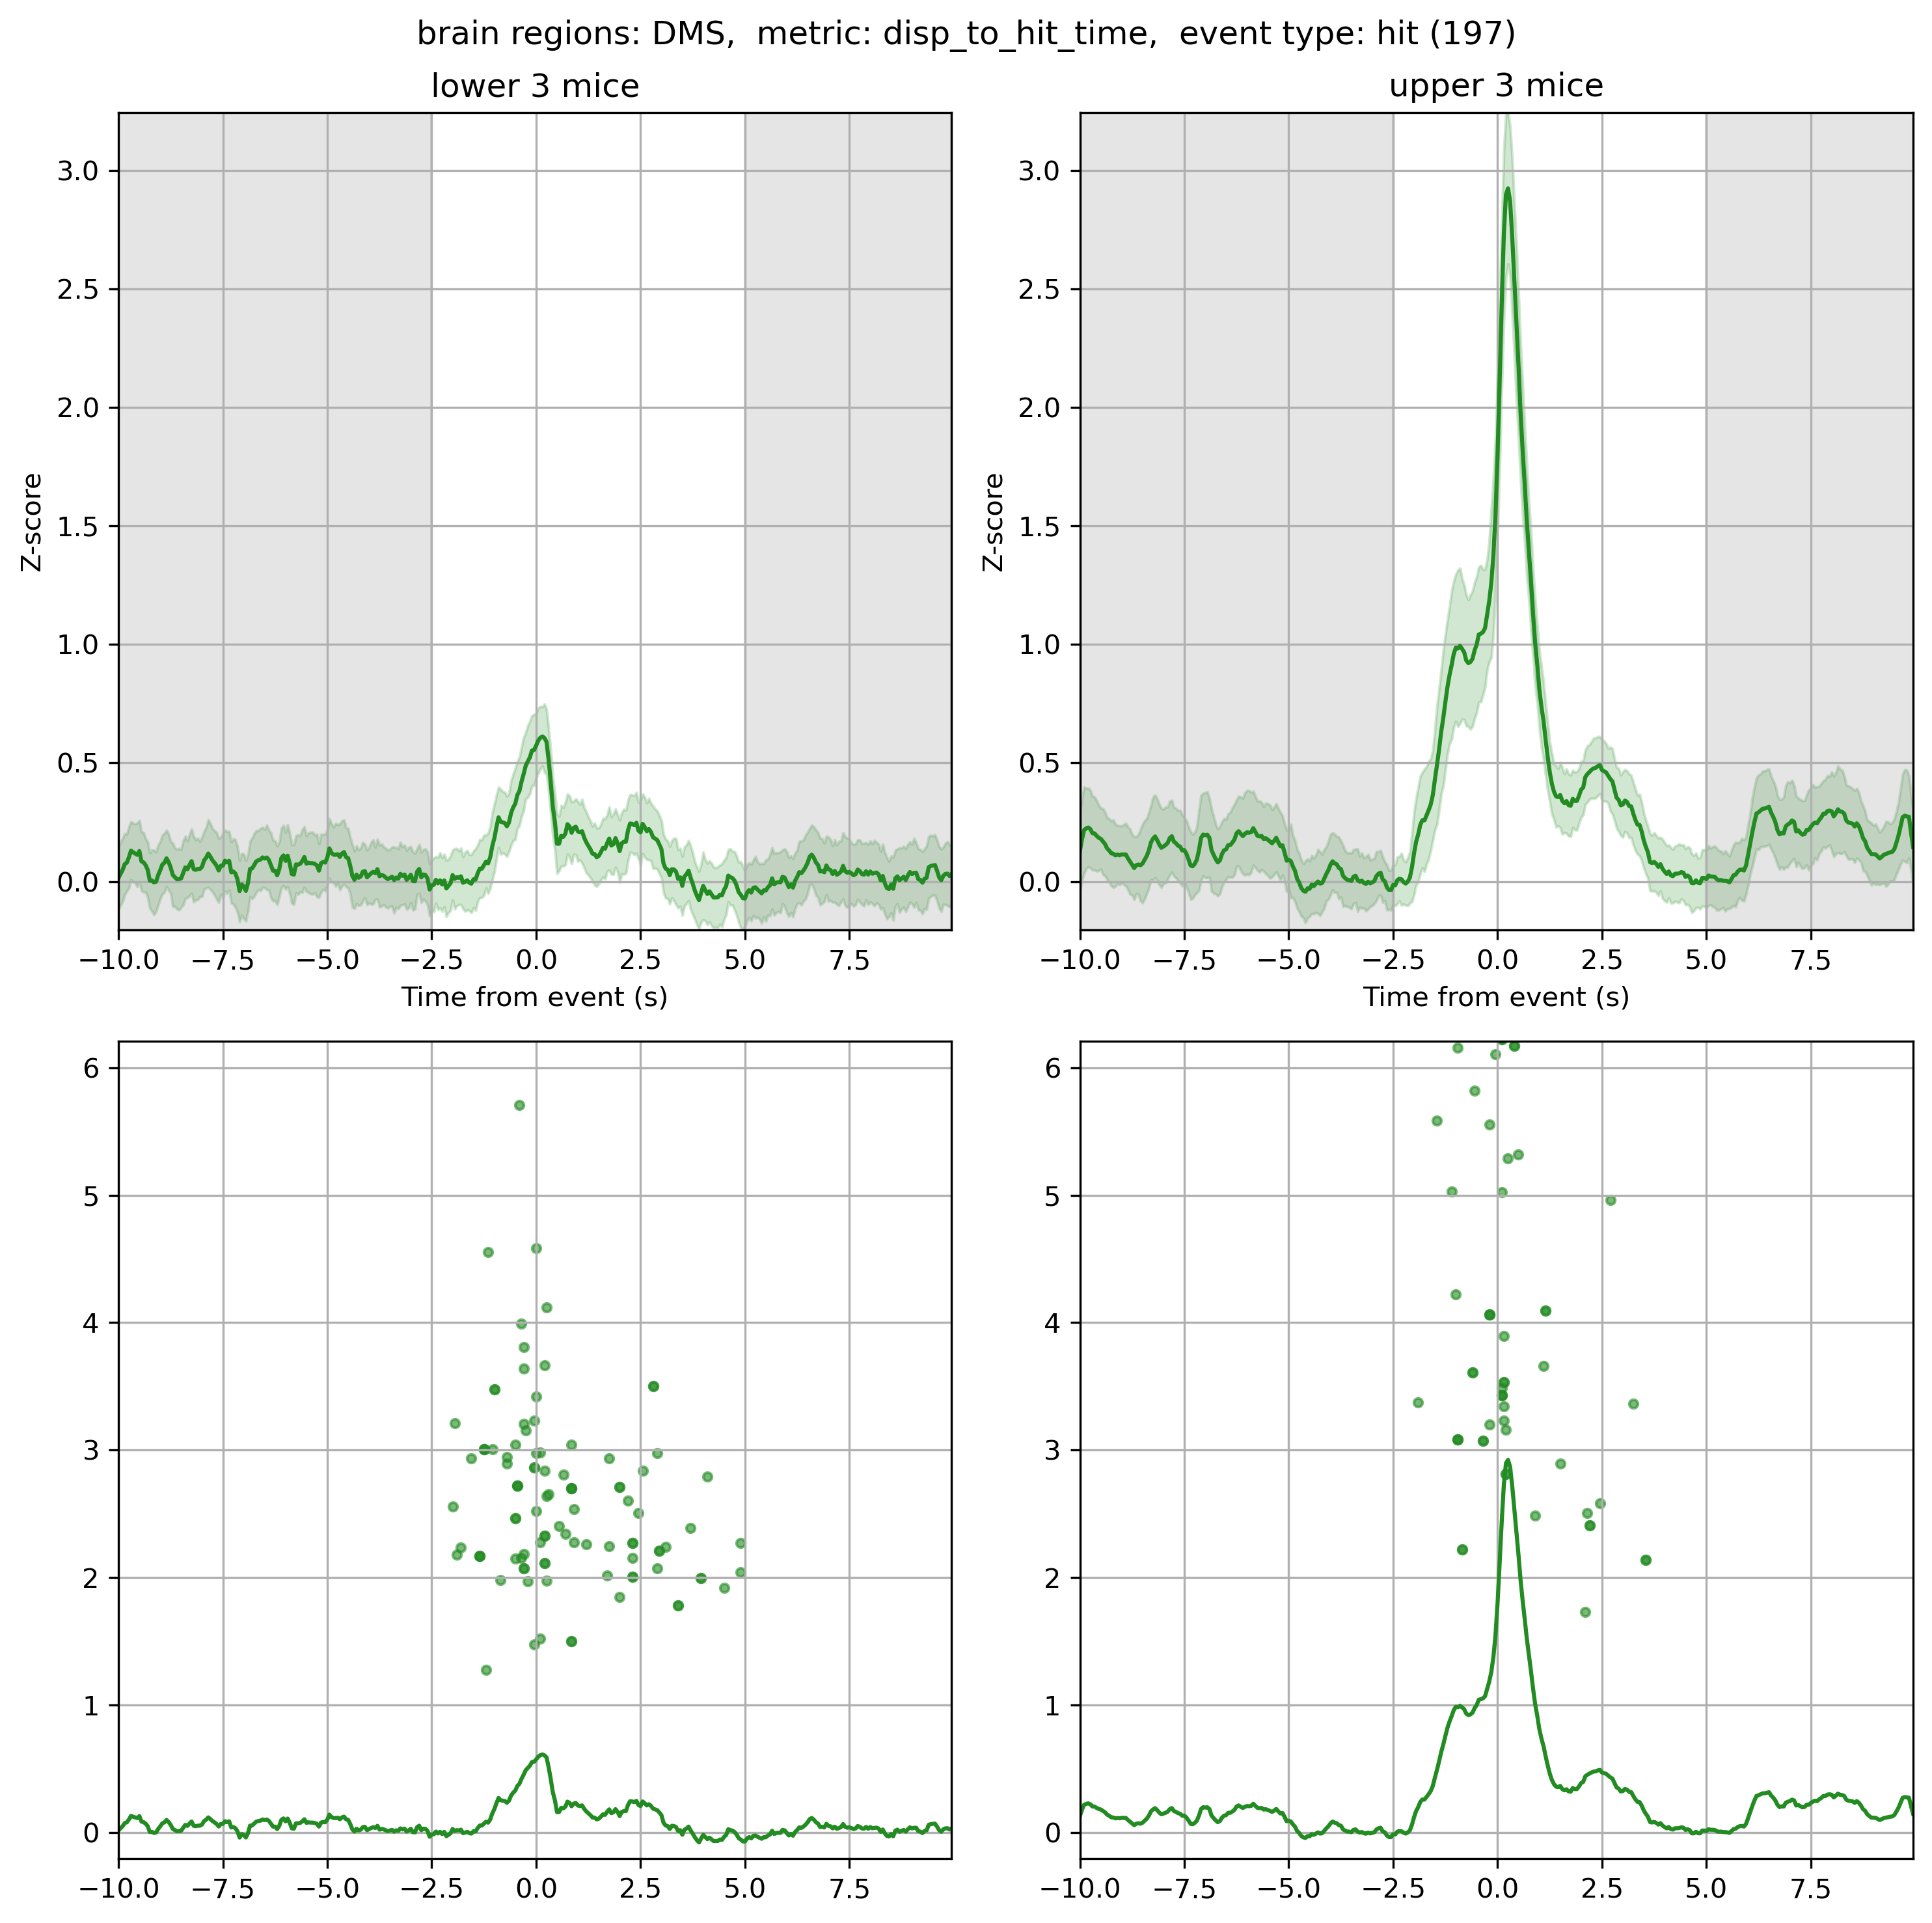

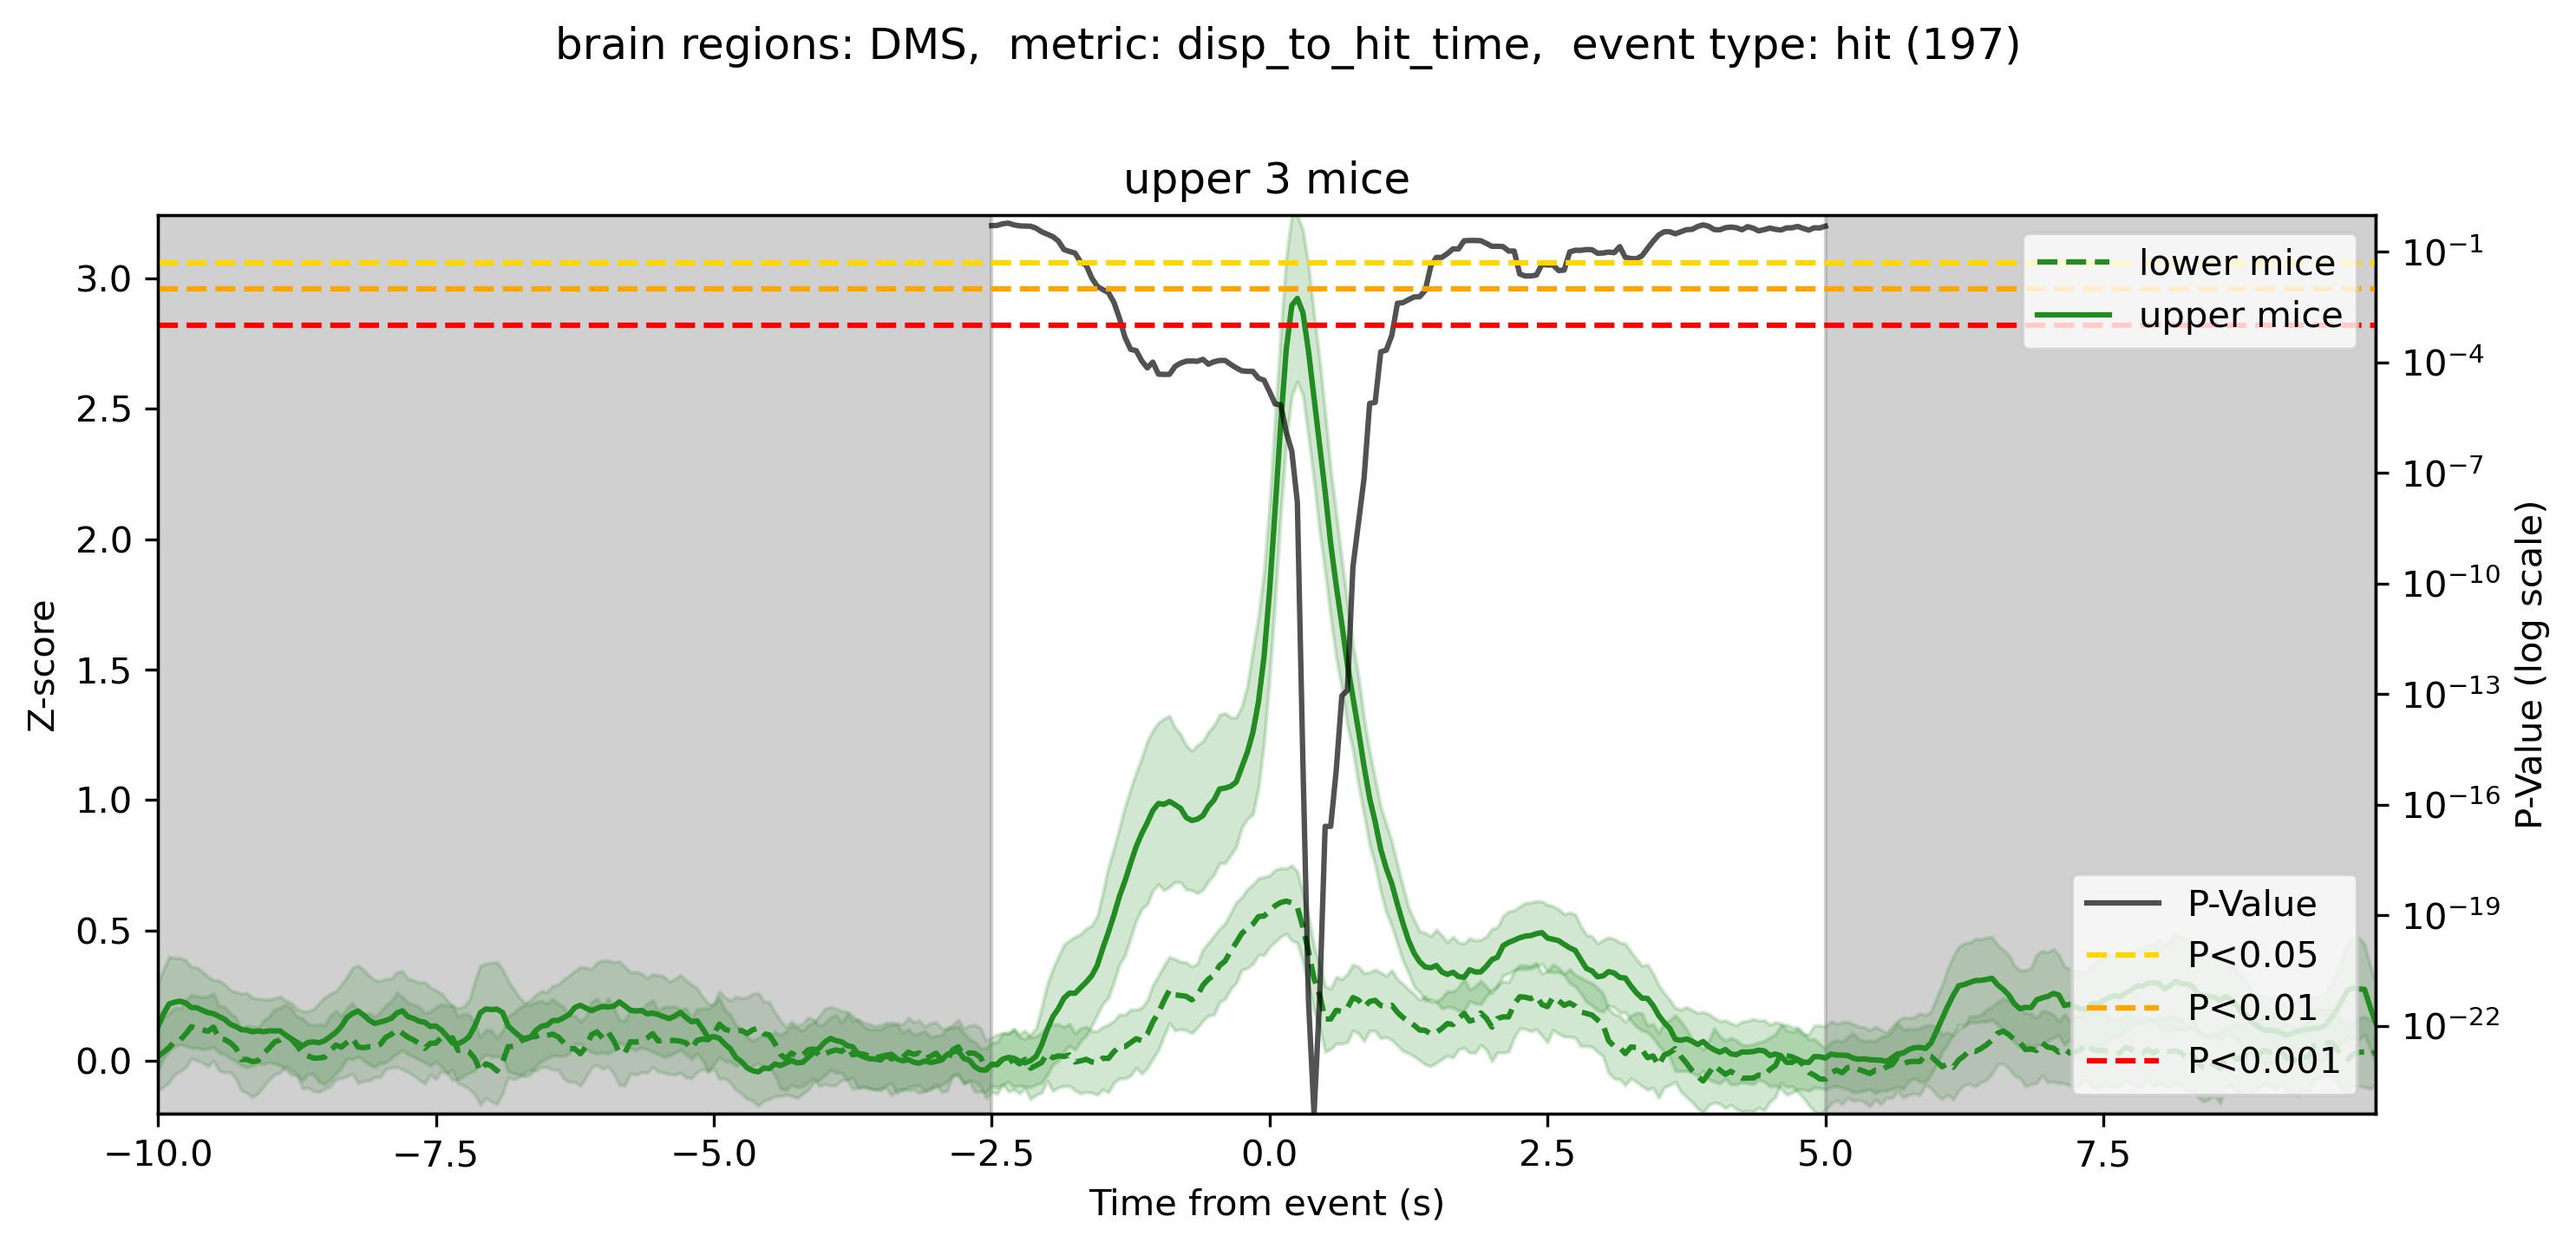

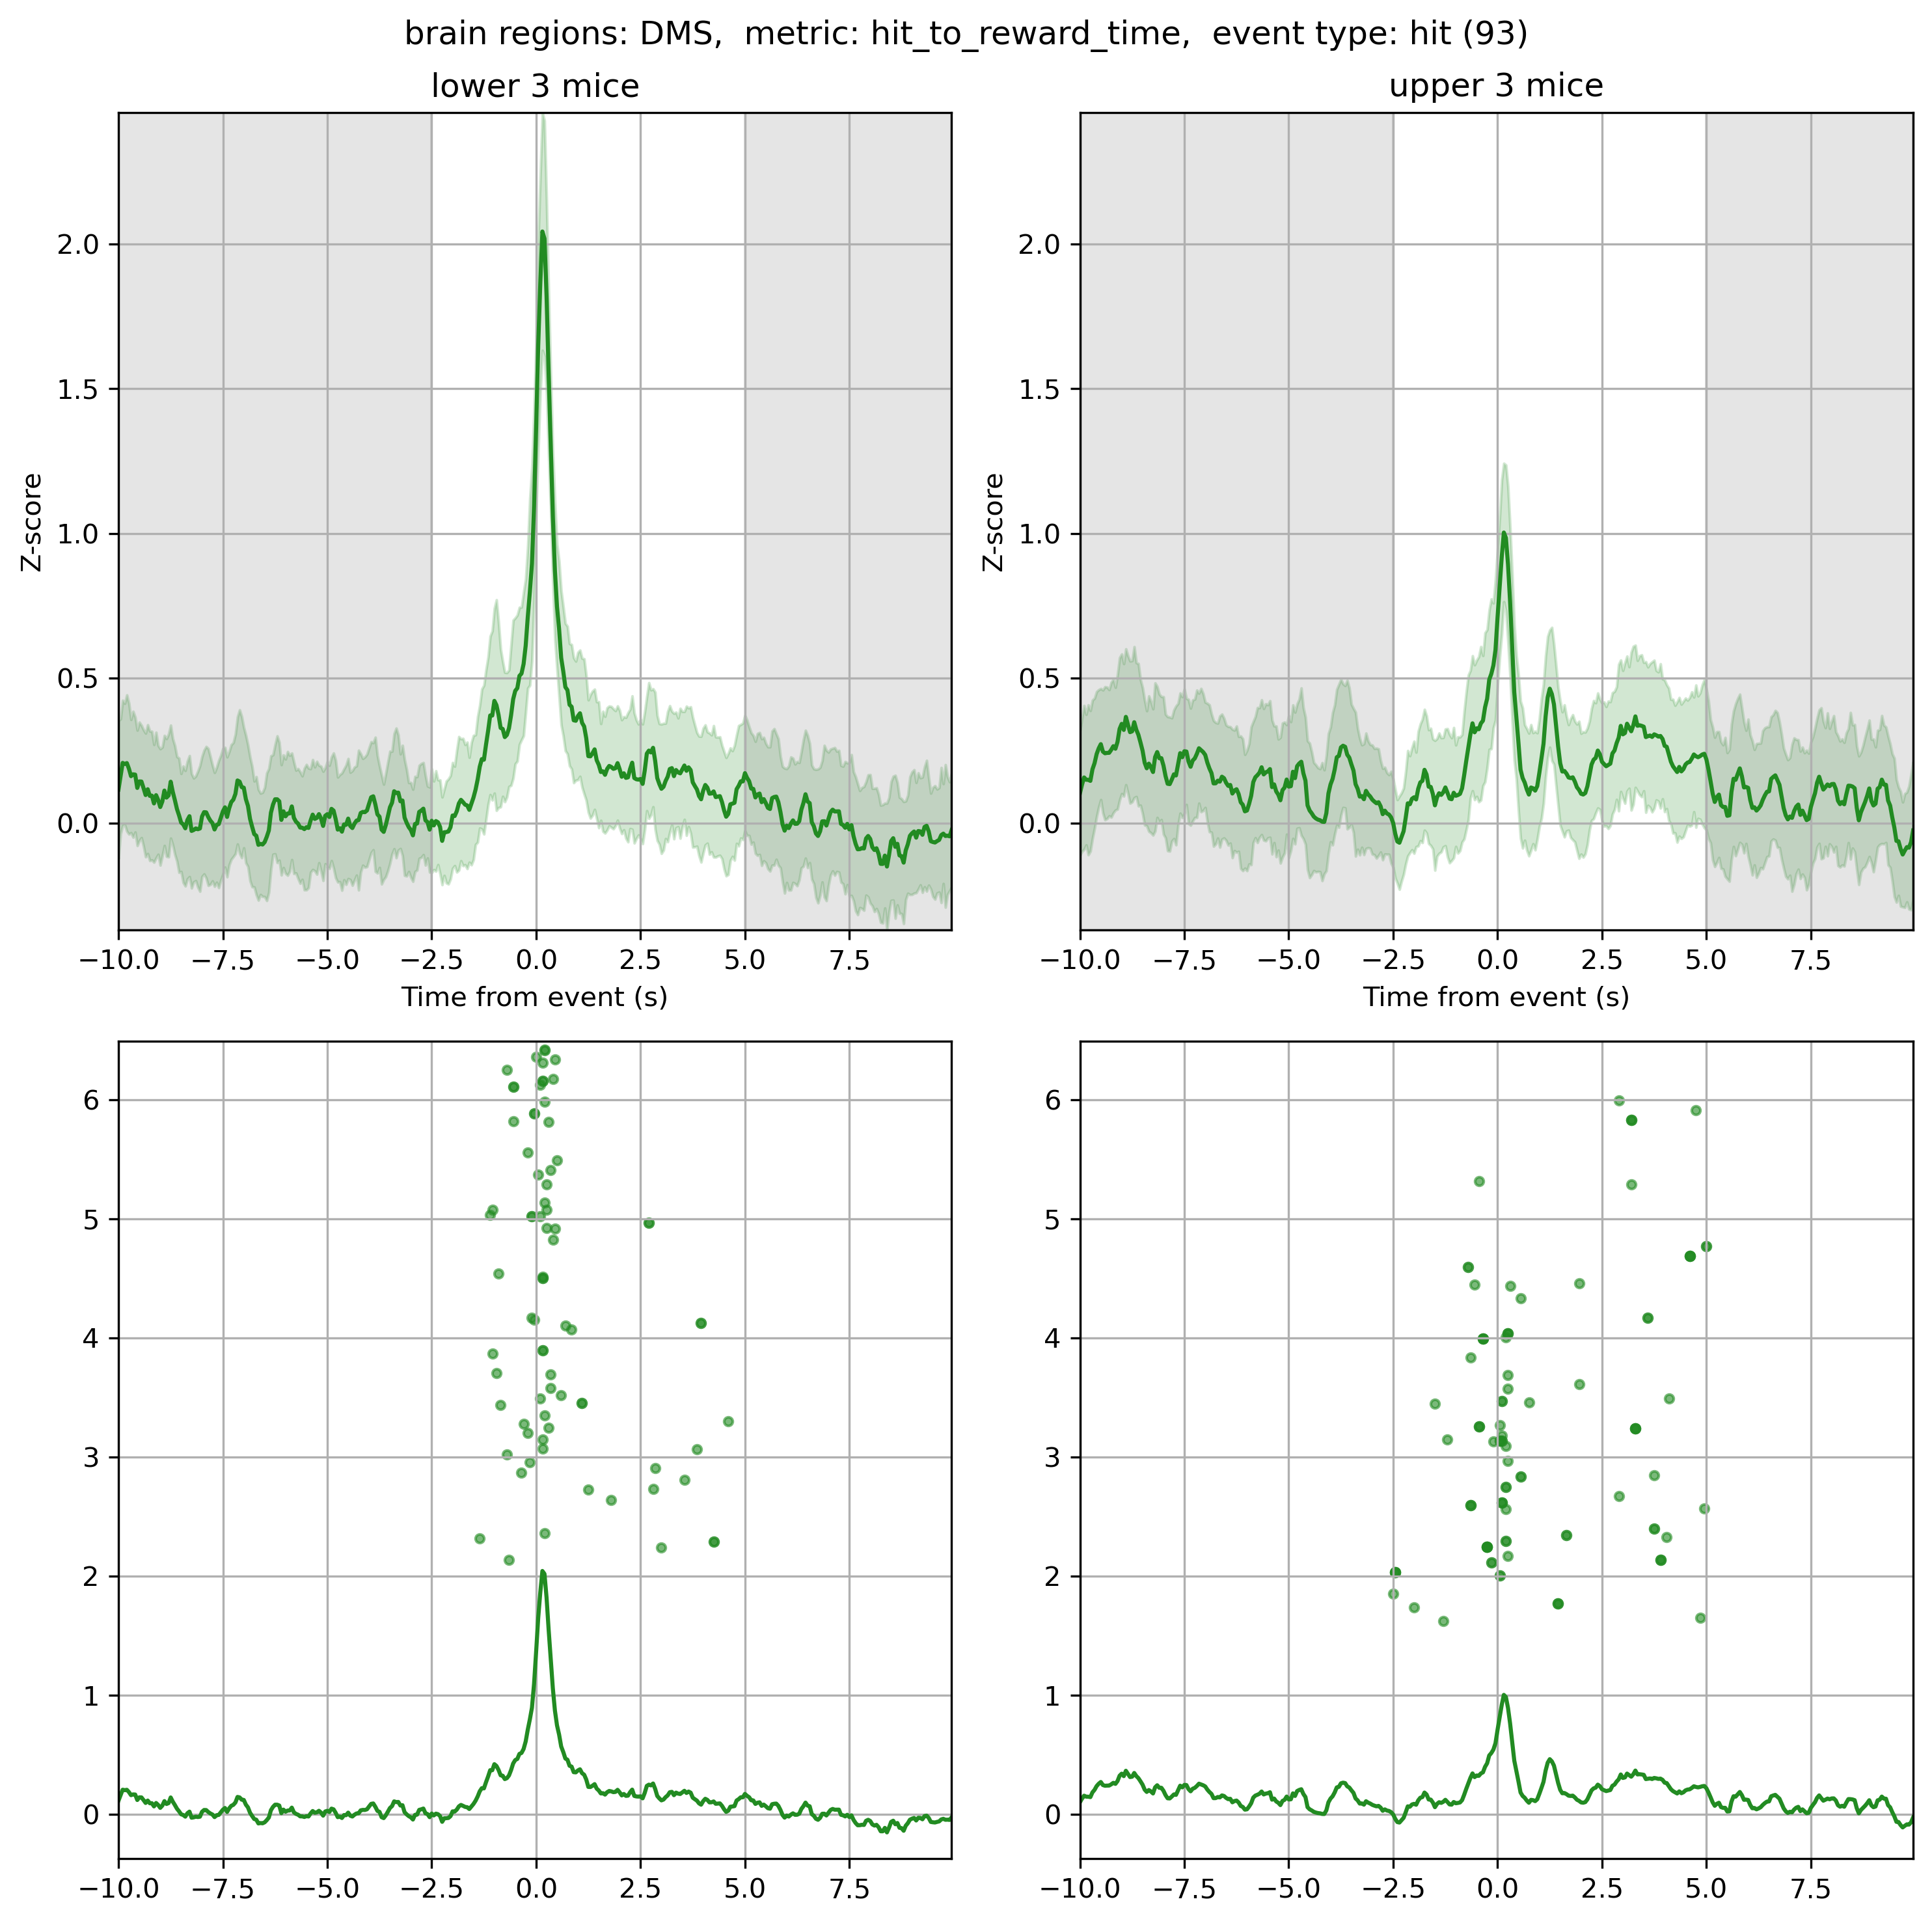

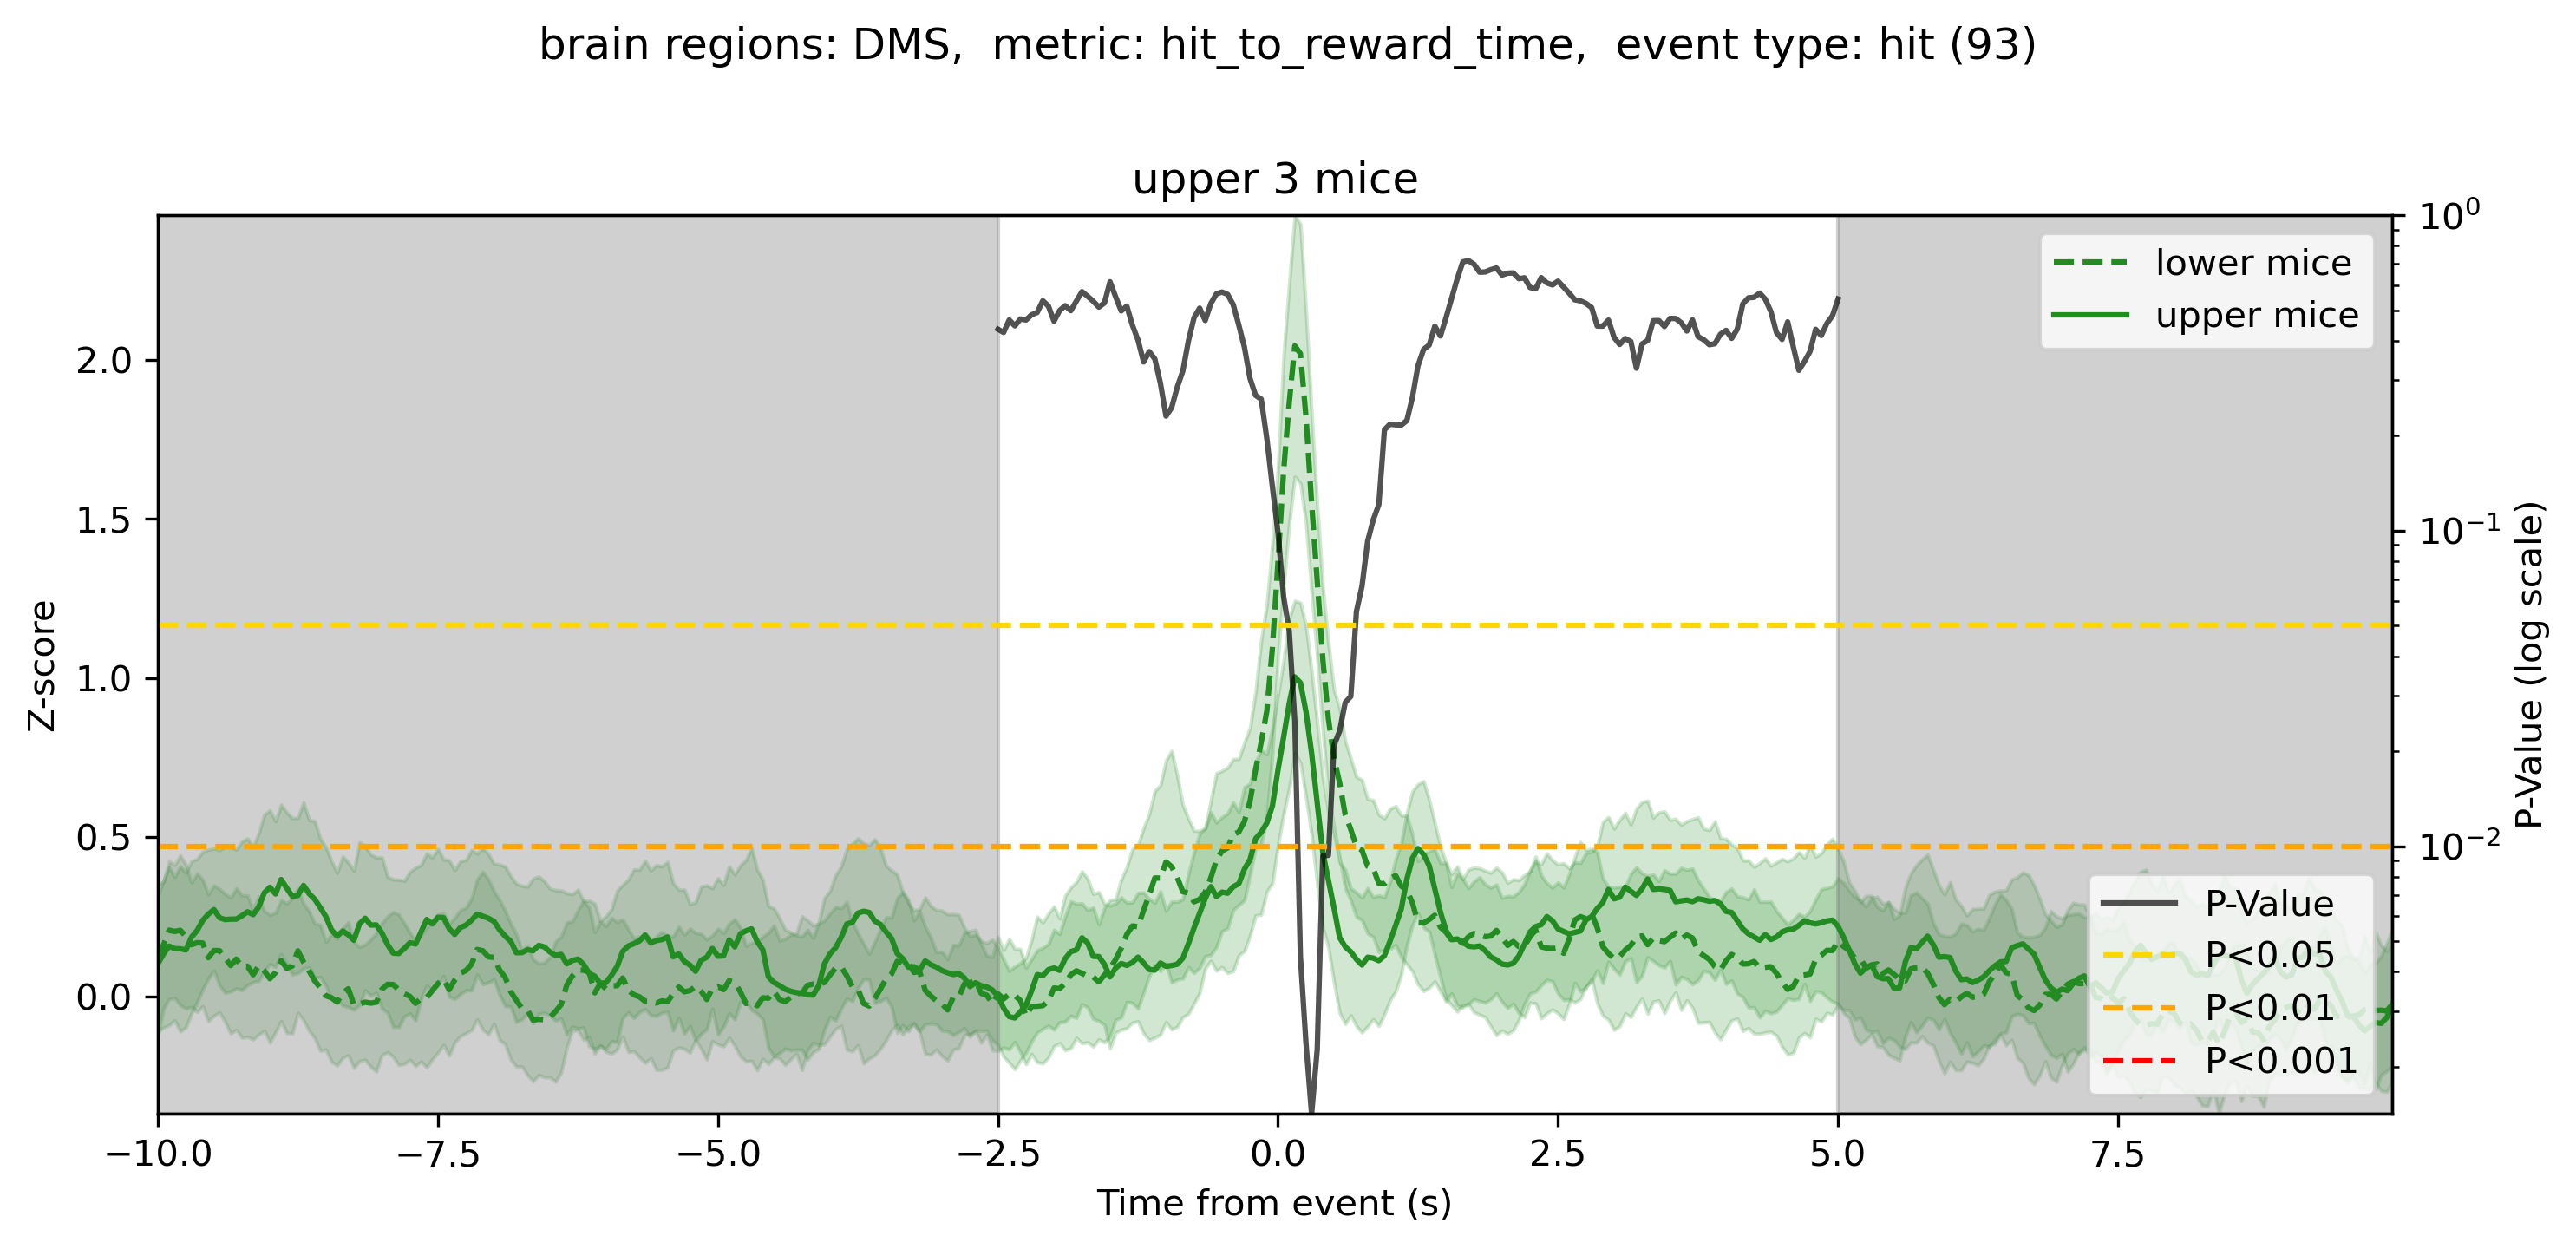

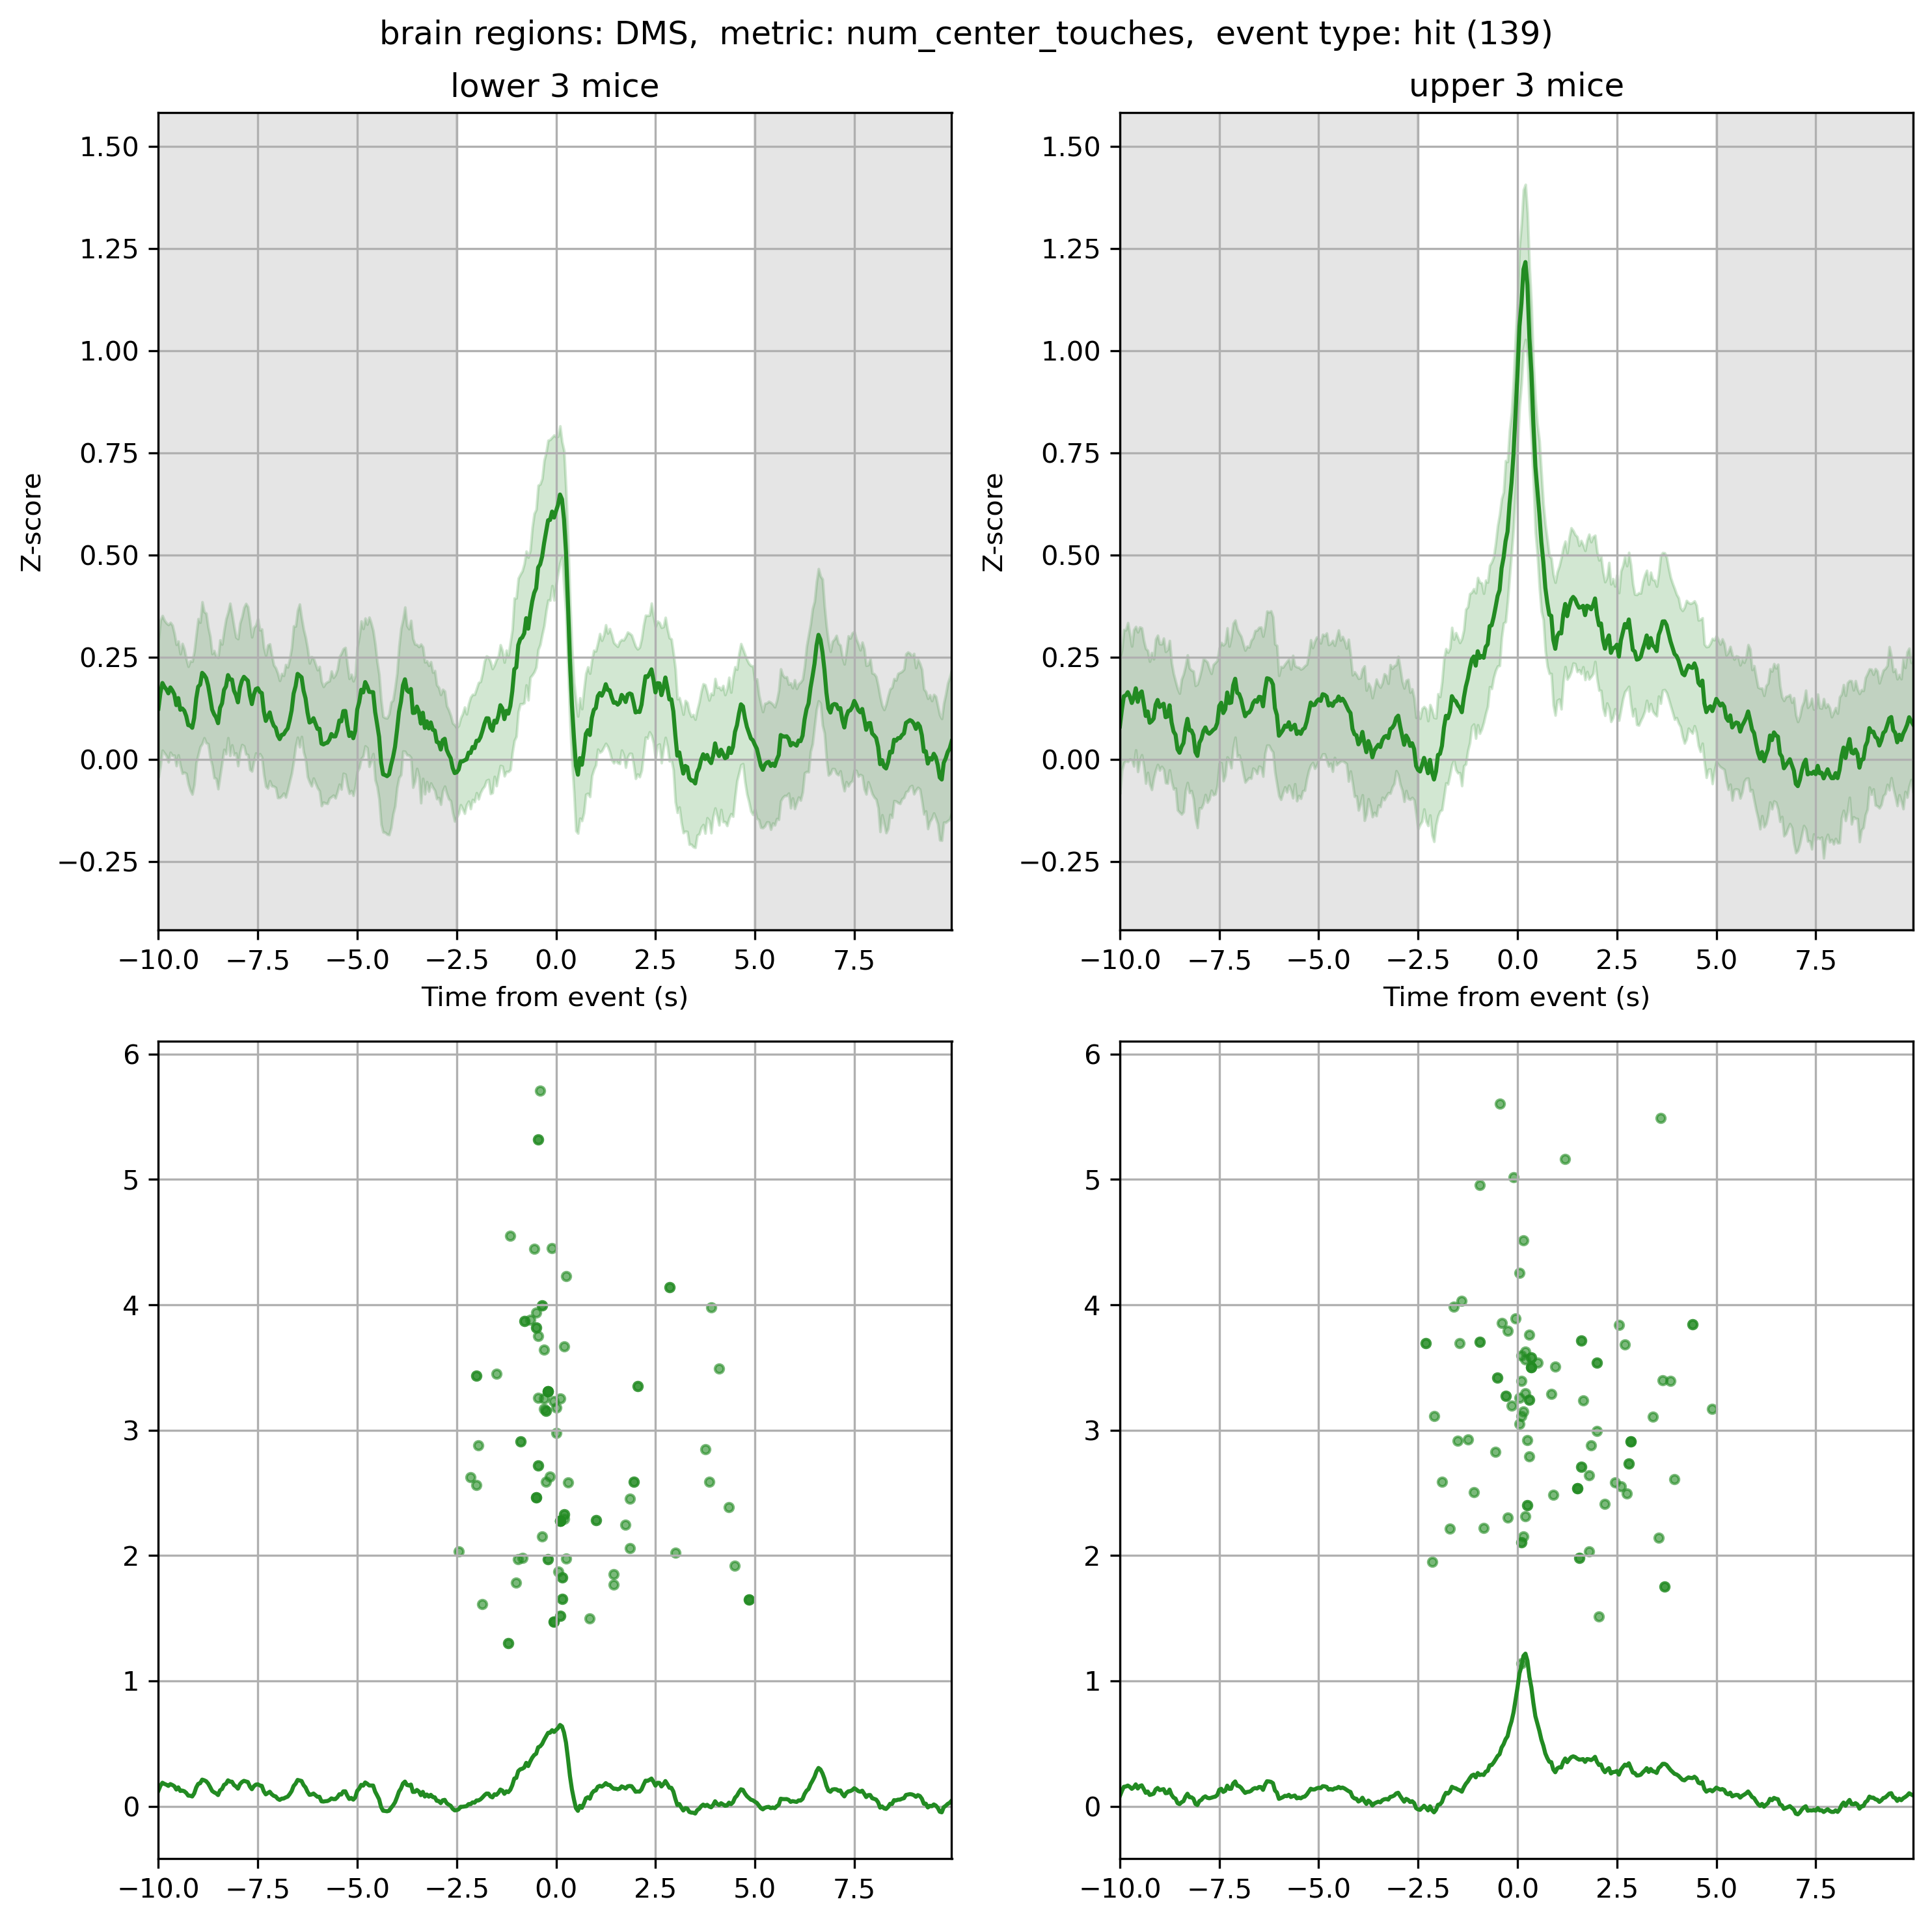

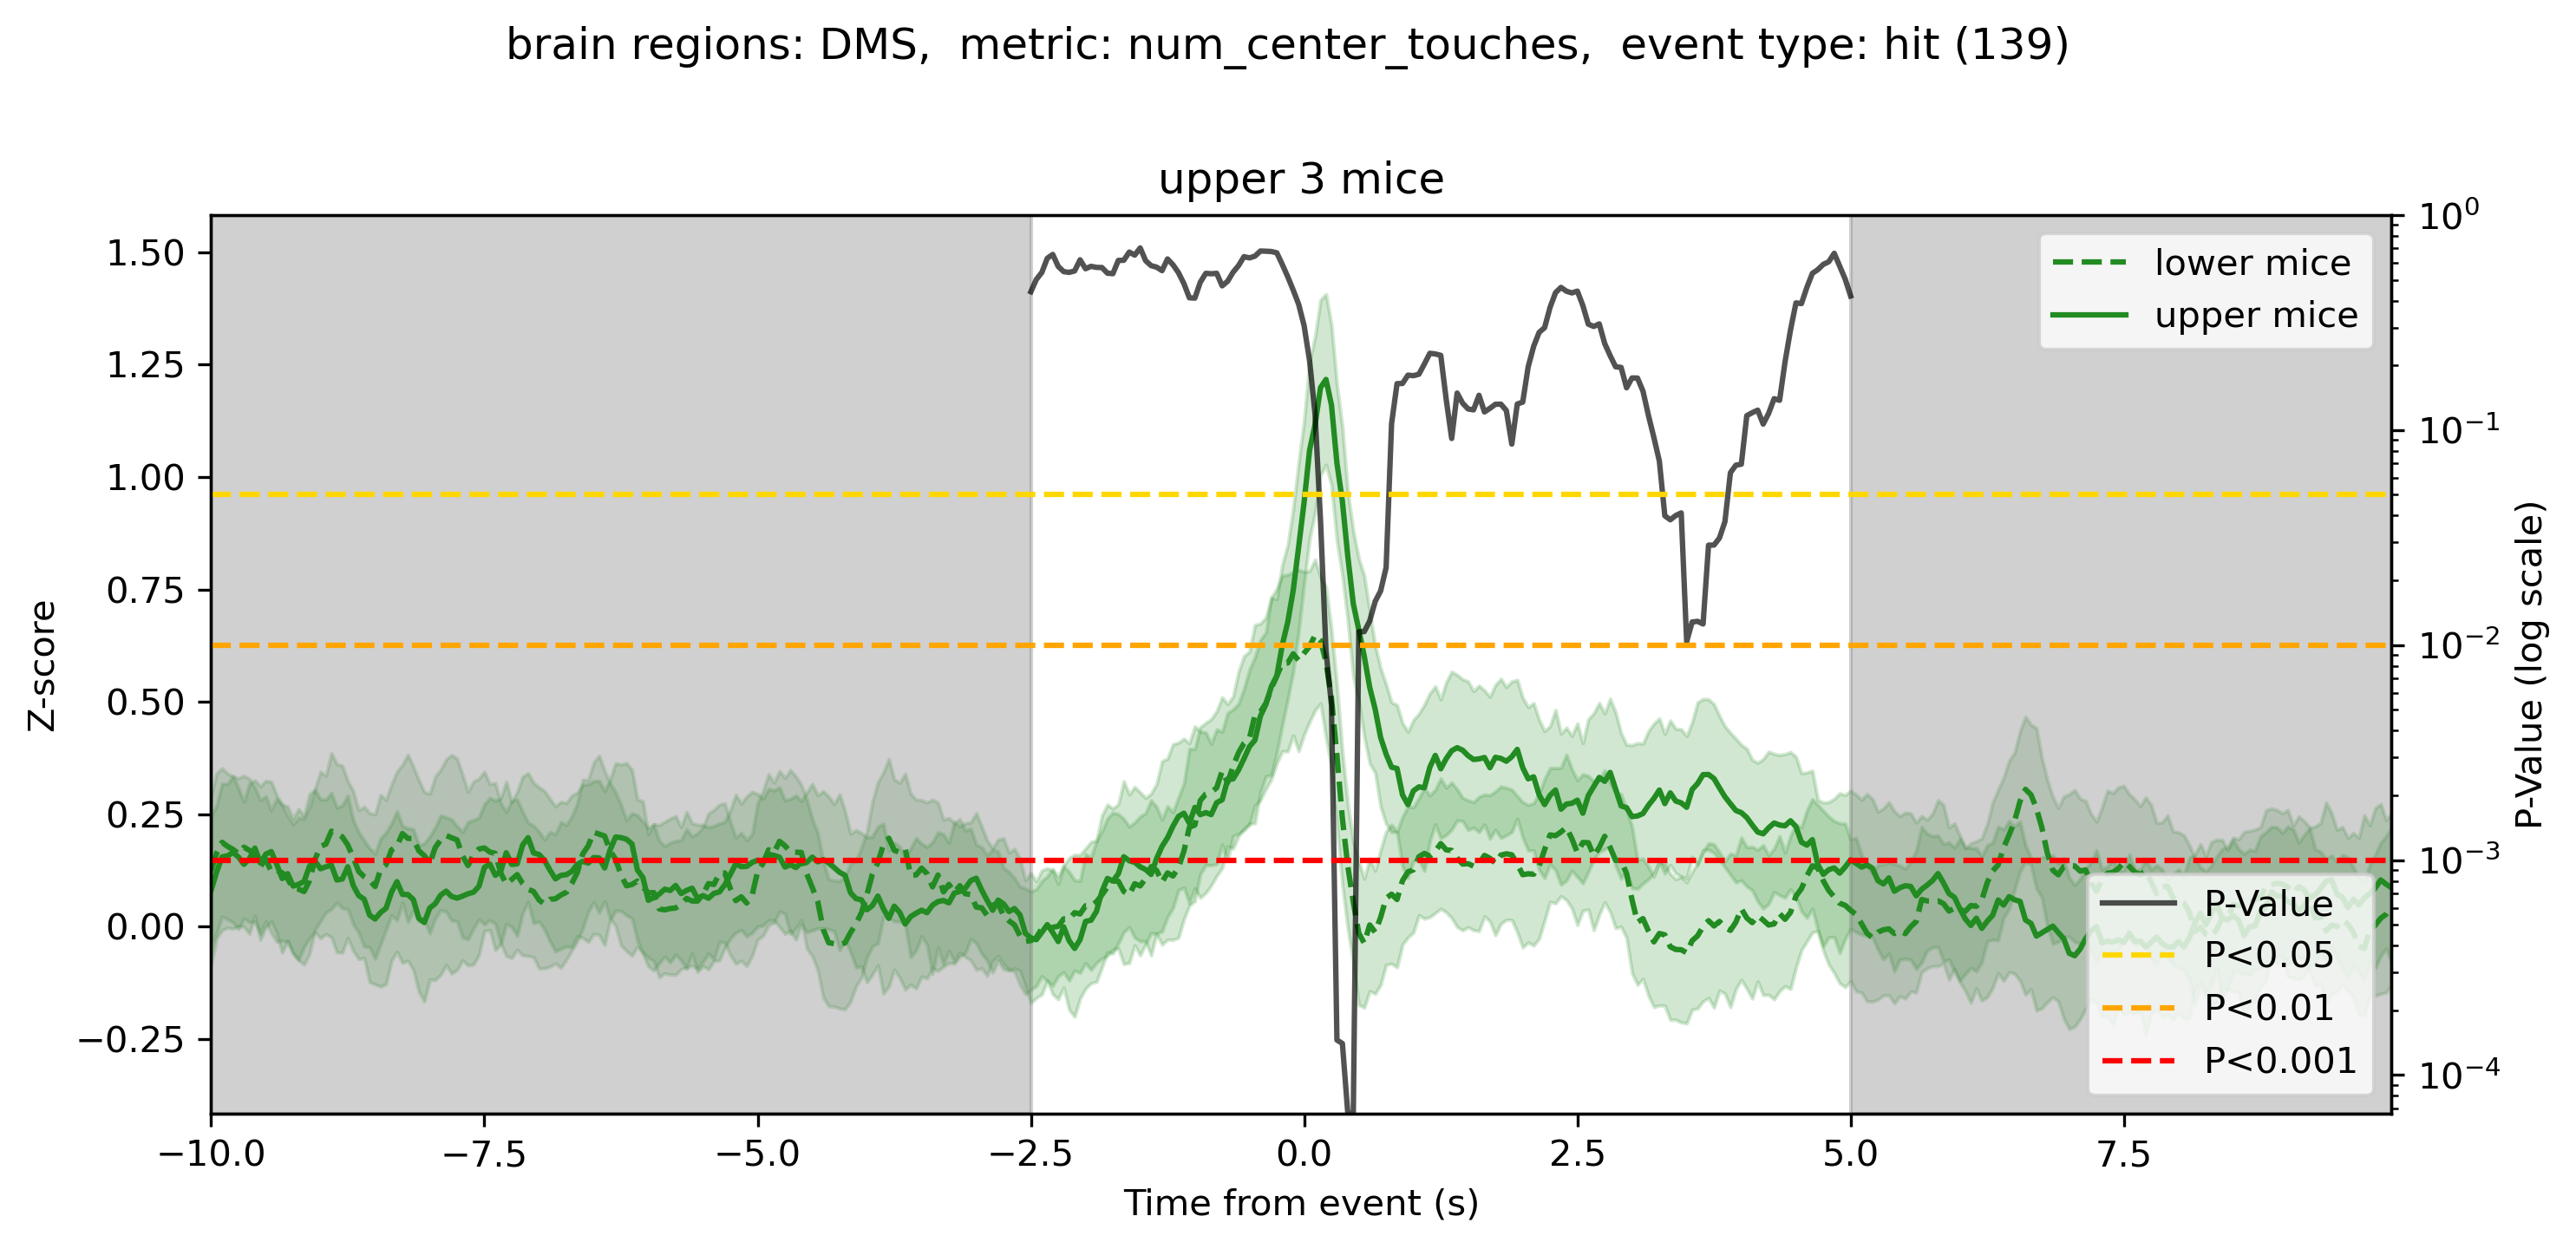

In [6]:
import itertools
import numpy as np
from scipy.stats import ttest_ind
from itertools import chain
from utils import mouse_br_events_count

# brain_reg_to_color = {'LH': 'orange',
#                       'mPFC': 'paleturquoise'}
brain_reg_to_color = {'VS': 'purple',
                      'DMS': 'forestgreen',
                      'DLS': 'C0'}

# Assuming config.all_metrics, config.all_brain_regions, and config.all_events are all iterable
for performance_metric, brain_region, event in itertools.product(all_metrics, ['DMS'], ['hit']):
    low_signals, high_signals, low_resp_metrics, high_resp_metrics, resp_metric_names = \
        sample_low_and_high_signals('events', performance_metric, brain_region, event, mouse_analyser, n=1000)

    sb = attr_interval_dict[event]
    scatters = [np.zeros((2, 100)), np.zeros((2, 100))]
    resp_metric_infos = []
    is_significant_p_vals = []


    low_sample_idxs = np.random.choice(len(low_resp_metrics), size=100, replace=True)
    high_sample_idxs = np.random.choice(len(high_resp_metrics), size=100, replace=True)
    for col_idx, resp_metric_name in resp_metric_names.items():
        low_resp_metric = low_resp_metrics[:, col_idx]
        high_resp_metric = high_resp_metrics[:, col_idx]

        if resp_metric_name == 'peak_timing':
            scatters[0][0] = (low_resp_metric + attr_interval_dict[event][0])[low_sample_idxs]
            scatters[1][0] = (high_resp_metric + attr_interval_dict[event][0])[high_sample_idxs]
        elif resp_metric_name == 'maximal_value':
            scatters[0][1] = low_resp_metric[low_sample_idxs]
            scatters[1][1] = high_resp_metric[high_sample_idxs]

        t_stat, p_value = ttest_ind(low_resp_metric, high_resp_metric, nan_policy='omit')
        resp_metric_infos.append(f"            {resp_metric_name}: t-stat: {t_stat:.3f},  p-value: {p_value:.3e}")
        is_significant_p_vals.append(p_value <= 1/3000)
    #     if p_value > 1/3000:
    #         continue
    # if not any(is_significant_p_vals):
    #     continue

    suptitle = f"brain regions: {brain_region},  metric: {performance_metric},  event type: {event} ({low_signals.shape[0]})"#\nresponse metrics: "
    # for resp_metric_info in resp_metric_infos:
    #     suptitle += f"\n{resp_metric_info}"

    low_subtitle = f"lower 3 mice"
    high_subtitle = f"upper 3 mice"

    t_stats = np.zeros(low_signals.shape[1])  # Assuming the second dimension is time
    p_values = np.zeros(low_signals.shape[1])
    
    # Perform a t-test at each time point
    for time_point in range(low_signals.shape[1]):
        t_stat, p_value = ttest_ind(low_signals[:, time_point], high_signals[:, time_point])
        t_stats[time_point] = t_stat
        p_values[time_point] = p_value

    color = brain_reg_to_color[brain_region]
    plot_signals([low_signals, high_signals], [low_subtitle, high_subtitle], suptitle, color, 
                    5, sb, scatters=scatters)#, fname=f'{performance_metric}_{brain_region}_{event}.png')
    
    plot_signals_p_values([low_signals, high_signals], [low_subtitle, high_subtitle], suptitle, color, 
                          5, sb, p_values, fname=None)#f'{performance_metric}_{brain_region}_{event}.png')
             